In [1]:
import torch
import os
import sys
import copy
import numpy as np
import random

from functools import cache

In [2]:
import matplotlib.ticker as mtick

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

In [4]:
import scipy.optimize
import matplotlib as mpl

from csaps import csaps
from scipy.interpolate import splrep, BSpline

In [5]:
import pygwalker as pyg

In [6]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [7]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]

':4096:8'

In [8]:
os.environ['NUMEXPR_MAX_THREADS'] = '16'

In [9]:
rand = 10
torch.manual_seed(rand)
torch.cuda.manual_seed(rand)
torch.cuda.manual_seed_all(rand)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(rand)
random.seed(rand)

In [10]:
def seed_everything(seed: int):
    r"""Sets the seed for generating random numbers in :pytorch:`PyTorch`,
    :obj:`numpy` and Python.

    Args:
        seed (int): The desired seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [11]:
import pandas as pd

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

In [14]:
import numpy as np
import networkx as nx

In [15]:
from torch_scatter import scatter_max, scatter_mean, scatter_min
from functools import lru_cache
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import ElasticNet, LinearRegression

In [16]:
import wandb

In [17]:
device = "cuda:0"

In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [20]:
from src.cv import crossvalidation, build_masks
from src.trainer import trainer
from src.cv import reset_model
from src.graph_construction import graph
from src.model import NullModel, CustomGAT

In [21]:
import matplotlib as mpl
import seaborn as sns

mpl.rc('image', cmap='Set1')

In [22]:
import torch_geometric.transforms as T
transform = T.Compose([T.ToUndirected(), T.AddSelfLoops()])

In [23]:
torch.use_deterministic_algorithms(True)
seed_everything(rand)

In [24]:
results_dir = os.path.join('results','e55')
os.makedirs(results_dir, exist_ok=True)

config = {
    "random_seed": rand,
    "custom_optimizer": torch.optim.Adam,
    "lr" : 0.01,
    'epochs': 500,
    'linear_layers': 2,
    'hidden_channels': 8,
    'dropout': 0.15,
    'test_percent': 15,
    'building_buffer': 400,
    'building_buffer_min':20,
    'building_buffer_max':1000,
    'building_buffer_npoints':5,
    'neighbor_radius': 100,
    'n_cv': 3,
    'n_cv_generalization':2,
    'cv_size': 1500,
    'graph_outchannels': 8,
    'graph_layers':1,
    'graph_heads':1,
    'partition_terms': [
        "road_area",
        "building_area",
        "sky_area",
        "vegetation_area",
        # "car_count",
        # "person_count"
    ]
}

generalization_range = range(0,100,20)

In [25]:
config['partition_terms']

['road_area', 'building_area', 'sky_area', 'vegetation_area']

In [26]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "w")
f.write(str("Config:\n"))
f.write(str(config))
f.close()

In [27]:
def pool_adjacency(graph, graph_auxillary):
    """Pools environmental features from the region for their use with regression"""
    # energy = scatter_mean(graph['footprint'].y, torch.tensor(graph_auxillary['rebuild_idx']).to(device))
    energy = graph['footprint'].y.detach().cpu()
    links = graph['footprint','contains','pano']['edge_index'].detach().cpu()
    
    panodata = graph['pano'].x.detach().cpu()
    link_source = panodata[links[1]]
    link_sink = links[0]
    features = scatter_mean(link_source, link_sink, dim=0)
    features_max = scatter_max(link_source, link_sink, dim=0)[0]
    features_min = scatter_min(link_source, link_sink, dim=0)[0]
    
    featurenames = graph_auxillary['node_data'].columns
    featuremin = featurenames + '_min'
    featuremax = featurenames + '_max'
    
    featuresdf = pd.DataFrame(panodata, columns = featurenames)
    featuresdfmax = pd.DataFrame(features_max, columns = featuremax)
    featuresdfmin = pd.DataFrame(features_min, columns = featuremin)
    return graph_auxillary['footprints'].join(featuresdf).join(featuresdfmax).join(featuresdfmin)

In [28]:
# g1, g1a = graph("new-york", **config)
# g1p = pool_adjacency(g1, g1a)

In [29]:
# g2, g2a = graph("san-francisco", **{ **config, **{"normalization":g1a["normalization"]} })
# g2p = pool_adjacency(g2, g2a)

In [30]:
# g3, g3a = graph("austin", **{ **config, **{"normalization":g1a["normalization"]} })
# g3p = pool_adjacency(g3, g3a)

In [31]:
config

{'random_seed': 10,
 'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.15,
 'test_percent': 15,
 'building_buffer': 400,
 'building_buffer_min': 20,
 'building_buffer_max': 1000,
 'building_buffer_npoints': 5,
 'neighbor_radius': 100,
 'n_cv': 3,
 'n_cv_generalization': 2,
 'cv_size': 1500,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area']}

In [32]:
g1, g1a = graph("new-york", **config)
g1a['footprints']['logenergy'] = np.log(g1a['footprints'].energy)
g1p = pool_adjacency(g1, g1a)

g2, g2a = graph("san-francisco", **{**config, **{"normalization": g1a["normalization"]}})
g2a['footprints']['logenergy'] = np.log(g2a['footprints'].energy)
g2p = pool_adjacency(g2, g2a)

g3, g3a = graph("austin", **{**config, **{"normalization": g1a["normalization"]}})
g3a['footprints']['logenergy'] = np.log(g3a['footprints'].energy)
g3p = pool_adjacency(g3, g3a)

In [34]:
g1

HeteroData(
  pano={ x=[106436, 4] },
  footprint={
    x=[13869, 3],
    y=[13869],
    train_mask=[13869],
    test_mask=[13869]
  },
  (footprint, contains, pano)={ edge_index=[2, 6954524] },
  (pano, links, pano)={ edge_index=[2, 4287142] },
  (pano, rev_contains, footprint)={ edge_index=[2, 6954524] }
)

In [33]:
g1p

,id,geometry,energy,area,year,hdd,cdd,logenergy,road_area,building_area,sky_area,vegetation_area,road_area_max,building_area_max,sky_area_max,vegetation_area_max,road_area_min,building_area_min,sky_area_min,vegetation_area_min
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485,6.929539,0.333034,2.028941,-0.779699,-0.679966,0.926126,3.018845,0.659886,3.624529,-2.453864,-1.232984,-2.402995,-0.679966
1,11640540857295396741,"POLYGON ((585824.204 4511010.579, 585801.557 4...",1976.070202,8779.345776,2012,1687.509132,5349.625418,7.588865,-0.314565,1.819050,-0.922271,-0.121712,0.926126,3.018845,0.659886,3.624529,-2.453864,-1.232984,-2.402995,-0.679966
2,2176611449573922396,"POLYGON ((585546.811 4510715.429, 585530.747 4...",4025.883834,15241.408783,2012,2738.533604,4674.101243,8.300500,-0.161960,2.045289,-0.742900,-0.626156,0.960556,3.047842,0.659886,3.565706,-2.453864,-1.232984,-2.402995,-0.679966
3,15634040336852848410,"POLYGON ((585476.710 4510964.643, 585463.466 4...",1698.343339,6851.234218,2012,1650.579136,5176.224177,7.437409,-0.320520,1.847950,-0.609387,-0.606616,0.909789,3.018845,0.432017,2.098002,-2.453864,-1.232984,-2.165785,-0.679966
4,14406020392858049933,"POLYGON ((585796.868 4510668.833, 585753.012 4...",3524.173769,20209.961074,2012,2027.315521,5382.643972,8.167401,-1.911157,1.691869,-0.838577,-0.679966,0.960556,3.025949,0.659886,3.624529,-2.453864,-1.232984,-2.402995,-0.679966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13867,15651345487193931624,"POLYGON ((590076.780 4509223.274, 589983.358 4...",436.916958,6038.703444,2012,1818.711056,5415.344122,6.079743,0.639619,0.435831,0.596385,-0.401402,0.842228,-0.609830,1.954352,3.652866,-2.453864,-1.232984,-2.122758,-0.679966
13868,17223719695729998017,"POLYGON ((589939.476 4509249.579, 589897.284 4...",419.785440,5852.897184,2012,1550.300903,5767.163863,6.039744,0.046298,0.262527,0.407013,-0.679966,0.842228,-0.003705,1.954352,3.652866,-2.453864,-1.232984,-2.122758,-0.679966
13869,12175045392502182871,"POLYGON ((592782.975 4507852.583, 592773.856 4...",127.623327,2608.069566,2017,2587.075502,4761.694998,4.849083,0.226463,1.073970,0.186598,-0.556387,0.881772,-0.045158,1.858109,2.750065,-2.453864,-1.232984,-1.735428,-0.679966
13870,14468115704619059393,"POLYGON ((594001.388 4507724.943, 593989.251 4...",178.697681,1928.668977,2016,2919.485011,4649.001118,5.185695,0.780468,-0.418914,1.231871,-0.679966,0.772605,-0.208925,1.765924,3.297986,-2.453864,-1.232984,-2.040103,-0.679966


In [34]:
g1a['node_data_original']

,pano_id,pano_date,geometry,id,car_area,building_area,truck_area,traffic light_area,person_area,road_area,...,pole_count,vegetation_count,motorcycle_count,truck_count,terrain_count,rider_count,traffic light_count,wall_count,bus_count,train_count
0,452361285632,2016-10,POINT (585579.517 4510738.733),452361285632,0.02038,0.33522,0.00059,0.00000,0.00301,0.36506,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,640492220416,2016-09,POINT (585642.403 4510745.145),640492220416,0.05920,0.31365,0.02564,0.00000,0.00413,0.28023,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,187815665664,2016-10,POINT (585584.048 4510746.828),187815665664,0.01224,0.33690,0.00000,0.00008,0.00232,0.30022,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,842426548224,2016-10,POINT (585589.154 4510755.719),842426548224,0.03089,0.31662,0.00000,0.00014,0.01272,0.27945,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,405474353152,2016-09,POINT (585623.048 4510755.803),405474353152,0.11244,0.30058,0.00176,0.00005,0.00835,0.07109,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106431,393328021504,2012-8,POINT (587907.918 4516326.555),393328021504,0.00000,0.00000,0.00000,0.00000,0.00000,0.22222,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
106432,573813997568,2012-8,POINT (587960.398 4516335.029),573813997568,0.00000,0.00073,0.00000,0.00000,0.00016,0.27186,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
106433,862391214080,2012-8,POINT (587966.142 4516338.974),862391214080,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
106434,317614780416,2012-8,POINT (587939.203 4516370.086),317614780416,0.00000,0.00000,0.00000,0.00000,0.00015,0.41925,...,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0


In [35]:
### first thing is first - getting statistics for each graph
nysum = g1a['node_data_original'][config['partition_terms']].agg([max, min, 'mean', 'median'])
nybsum = g1a['footprints'][['energy','area','year','hdd','cdd']].agg([max, min, 'mean', 'median'])

nysum = pd.concat([nybsum, nysum], axis=1)
# nysum['city'] = np.repeat('New York City', len(nysum))
# nysum = nysum.set_index('city')

sfsum = g2a['node_data_original'][config['partition_terms']].agg([max, min, 'mean', 'median'])
sfbsum = g2a['footprints'][['energy','area','year','hdd','cdd']].agg([max, min, 'mean', 'median'])

sfsum = pd.concat([sfbsum, sfsum], axis=1)

# sfsum['city'] = np.repeat('San Francisco', len(sfsum))
# sfsum = sfsum.set_index('city')

ausum = g3a['node_data_original'][config['partition_terms']].agg([max, min, 'mean', 'median'])
aubsum = g3a['footprints'][['energy','area','year','hdd','cdd']].agg([max, min, 'mean', 'median'])

ausum = pd.concat([aubsum, ausum], axis=1)

# ausum['city'] = np.repeat('Austin', len(ausum))
# ausum = ausum.set_index('city')

In [36]:
sfbsum = g2a['footprints'][['energy','area','year','hdd','cdd']].agg([max, min, 'mean', 'median'])

In [37]:
pd.concat([sfbsum, sfsum], axis=1)

,energy,area,year,hdd,cdd,energy,area,year,hdd,cdd,road_area,building_area,sky_area,vegetation_area
max,28112.885058,47365.386811,2021.000000,426.474943,9489.211279,28112.885058,47365.386811,2021.000000,426.474943,9489.211279,0.504700,0.632930,0.485030,0.600580
min,5.379747,743.224000,2012.000000,0.000000,4850.312246,5.379747,743.224000,2012.000000,0.000000,4850.312246,0.000000,0.000000,0.000200,0.000000
mean,1441.643780,8174.383995,2014.564051,36.310424,7270.001179,1441.643780,8174.383995,2014.564051,36.310424,7270.001179,0.246888,0.108368,0.328776,0.055246
median,680.396308,4593.681738,2013.000000,0.000000,7239.241519,680.396308,4593.681738,2013.000000,0.000000,7239.241519,0.241830,0.096570,0.343650,0.033815


In [38]:
env_data_summary = pd.concat([nysum, sfsum, ausum], axis=0, keys=('New York City', 'San Francisco', 'Austin'))
env_data_summary = env_data_summary.rename(
    columns={
        "energy":"Energy",
        "area":"Area",
        "year":"Year",
        "cdd":"CDD",
        "hdd":"HDD",
        "road_area":"Road Area", 
        "building_area":"Building Area", 
        "sky_area":"Sky Area", 
        "vegetation_area":"Vegetation Area"
    })

In [39]:
print(env_data_summary.style.format(decimal='.', thousands=',', precision=3).to_latex())

\begin{tabular}{llrrrrrrrrr}
 &  & Energy & Area & Year & HDD & CDD & Road Area & Building Area & Sky Area & Vegetation Area \\
\multirow[c]{4}{*}{New York City} & max & 5,376,747.404 & 50,304.072 & 2,017.000 & 4,149.093 & 7,588.287 & 0.602 & 0.649 & 0.491 & 0.810 \\
 & min & 0.360 & 27.871 & 2,012.000 & 185.346 & 2,183.404 & 0.000 & 0.000 & 0.000 & 0.000 \\
 & mean & 9,245.888 & 9,624.112 & 2,014.149 & 2,791.044 & 4,789.228 & 0.321 & 0.127 & 0.257 & 0.066 \\
 & median & 1,649.080 & 6,503.219 & 2,012.000 & 2,920.931 & 4,794.382 & 0.366 & 0.111 & 0.265 & 0.021 \\
\multirow[c]{4}{*}{San Francisco} & max & 28,112.885 & 47,365.387 & 2,021.000 & 426.475 & 9,489.211 & 0.505 & 0.633 & 0.485 & 0.601 \\
 & min & 5.380 & 743.224 & 2,012.000 & 0.000 & 4,850.312 & 0.000 & 0.000 & 0.000 & 0.000 \\
 & mean & 1,441.644 & 8,174.384 & 2,014.564 & 36.310 & 7,270.001 & 0.247 & 0.108 & 0.329 & 0.055 \\
 & median & 680.396 & 4,593.682 & 2,013.000 & 0.000 & 7,239.242 & 0.242 & 0.097 & 0.344 & 0.034 \\
\mult

<AxesSubplot: >

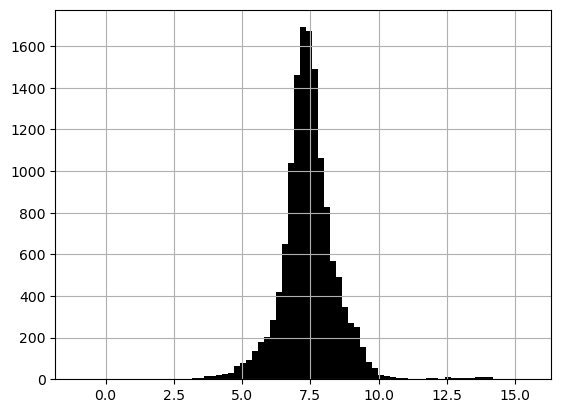

In [40]:
np.log(g1a['footprints'].energy).hist(bins=75, color="black")

In [41]:
g1p.drop(columns=["id","geometry","year"]).describe()

,energy,area,hdd,cdd,logenergy,road_area,building_area,sky_area,vegetation_area,road_area_max,building_area_max,sky_area_max,vegetation_area_max,road_area_min,building_area_min,sky_area_min,vegetation_area_min
count,1.387200e+04,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000
mean,9.245888e+03,9624.112161,2791.043777,4789.228452,7.454696,0.004229,0.183682,-0.163986,-0.010580,1.025846,2.340764,1.339733,3.747979,-2.449549,-1.231889,-2.350785,-0.679966
std,1.203647e+05,8808.004385,564.135391,563.774230,1.077664,0.972004,1.020693,0.916671,0.981568,0.177070,0.981544,0.480695,0.745344,0.096941,0.020490,0.195905,0.000045
min,3.597384e-01,27.870939,185.345664,2183.403795,-1.022378,-2.453864,-1.232984,-2.420639,-0.679966,0.399375,-1.209436,-0.323961,-0.615209,-2.453864,-1.232984,-2.421205,-0.679966
25%,1.026889e+03,4145.012495,2498.719080,4426.372498,6.934289,0.056890,-0.629243,-0.720774,-0.679966,0.933837,1.616749,1.038064,3.438752,-2.453864,-1.232984,-2.409883,-0.679966
50%,1.649080e+03,6503.219093,2920.930778,4794.381970,7.407973,0.324064,0.094381,-0.109679,-0.438281,0.985367,2.245644,1.433603,3.800997,-2.453864,-1.232984,-2.397145,-0.679966
75%,2.826627e+03,11391.572757,3178.775336,5157.361963,7.946839,0.569844,0.868069,0.517315,0.244856,1.046668,3.018845,1.683457,4.086620,-2.453864,-1.232984,-2.365418,-0.679966
max,5.376747e+06,50304.071944,4149.092892,7588.287268,15.497594,1.306075,3.640053,2.104661,5.455707,2.145595,5.084089,2.207792,7.611176,0.416551,-0.228678,1.296882,-0.679966


In [42]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(g1p.drop(columns=["id","geometry","year"]).describe())

            energy      area       hdd       cdd  logenergy  road_area  \
count    13,872.00 13,872.00 13,872.00 13,872.00  13,872.00  13,872.00   
mean      9,245.89  9,624.11  2,791.04  4,789.23       7.45       0.00   
std     120,364.67  8,808.00    564.14    563.77       1.08       0.97   
min           0.36     27.87    185.35  2,183.40      -1.02      -2.45   
25%       1,026.89  4,145.01  2,498.72  4,426.37       6.93       0.06   
50%       1,649.08  6,503.22  2,920.93  4,794.38       7.41       0.32   
75%       2,826.63 11,391.57  3,178.78  5,157.36       7.95       0.57   
max   5,376,747.40 50,304.07  4,149.09  7,588.29      15.50       1.31   

       building_area  sky_area  vegetation_area  road_area_max  \
count      13,872.00 13,872.00        13,872.00      13,872.00   
mean            0.18     -0.16            -0.01           1.03   
std             1.02      0.92             0.98           0.18   
min            -1.23     -2.42            -0.68           0.40   
25%

In [43]:
# from src.graph_construction import graph
# g1, g1a = graph(
#     "new-york",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )
# trainids, testids = build_corpus(g1, g1a)

# # nycgraph = transform(nycgraph)

In [44]:
idpool = g1a['footprints'].id
idtrain = idpool[g1a['training_mask'].detach().cpu().numpy()]
idtest = idpool[g1a['test_mask'].detach().cpu().numpy()]

### at this point, starting to train the model based on the new york data. m1 will be the linear model with no auxillary features, m2 will be the remote sensing data, m3 will be the comprehensive data

In [45]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
f.write(str("\n\n"))
f.write(str("NY Graph:\n"))
f.write(str(g1))
f.close()

In [46]:
def build_corpus(graphobj, graphdata):
    trainids = []
    testids = []

    training_corpus = pool_adjacency(graphobj, graphdata).iloc[graphdata['training_mask'].detach().cpu().numpy()].reset_index(drop=True)

    kf = KFold(n_splits=config['n_cv'], random_state=rand, shuffle=True)
    for train, test in kf.split(training_corpus):
        trainids.append(training_corpus.id[train])
        testids.append(training_corpus.id[test])
        
    return trainids, testids

In [47]:
def custom_cv(model, training_corpus, trainids, testids):
    """This needs to implement cross validation but only using hte set which is found in the first radius search of the building"""
    losses = []
    abslosses = []
    totalhashsum = 0
    for c,i in enumerate(trainids):
        custom_model = copy.deepcopy(model)
        training = training_corpus.loc[training_corpus.id.isin(i)]
        testing = training_corpus.loc[training_corpus.id.isin(testids[c])]
        
        training = training.sort_values(by="id").reset_index(drop=True)
        testing = testing.sort_values(by="id").reset_index(drop=True)
        
        # hashsum = int(pd.util.hash_pandas_object(training.id).sum()) % 1000
        # totalhashsum += hashsum
                
        X = np.array(training.drop(columns=["id","geometry","energy","year"]))
        y = np.array(training["energy"])
        custom_model.fit(X,y)
        
        Xt = np.array(testing.drop(columns=["id","geometry","energy","year"]))
        yt = np.array(testing["energy"])
        yhat = custom_model.predict(Xt)
        
        # in this case, the Y term is already not normalized
        losses.append(np.power(((yhat - yt)**2).mean(axis=None), 0.5))
        abslosses.append(np.abs(yhat - yt).mean(axis=None))
        
    # print(f"Total Hashsum: {totalhashsum}")
    return (losses, abslosses)

In [48]:
distances = np.linspace(
    config['building_buffer_min'], 
    config['building_buffer_max'], 
    config['building_buffer_npoints']
)

In [49]:
# print(f"N Training: {len(trainids[0])}\nN Testing: {len(testids[0])}")

In [50]:
# print(f"Losses:\n\nM1: {m1_rmse:,.2f}\nM2: {m2_rmse:,.2f}\nM3: {m3_rmse:,.2f}")

In [51]:
# print(f"Losses:\n\nM4: {m4_rmse:,.2f}\nM5: {m5_rmse:,.2f}\nM6: {m6_rmse:,.2f}")

In [52]:
# np.mean(losses) / 1e6

In [53]:
# np.mean(abslosses)

In [54]:
# from src.graph_construction import graph
# sfgraph, sf_rebuild_info = graph(
#     "san-fransisco",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )

In [55]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
f.write(str("\n\n"))
f.write(str("San Fransisco Graph:\n"))
f.write(str(g2))
f.close()

In [56]:
# from src.graph_construction import graph
# austingraph, austin_rebuild_info = graph(
#     "austin",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )

In [57]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
f.write(str("\n\n"))
f.write(str("Austin Graph:\n"))
f.write(str(g3))
f.close()

In [58]:
(~g1a['training_mask']).sum()

tensor(2080, device='cuda:0')

In [59]:
g1a['training_mask'].sum()

tensor(11792, device='cuda:0')

In [60]:
loss_func = torch.nn.MSELoss()

In [61]:
# lossing_func = torch.nn.MSELoss()

In [62]:
# loss_func = lambda x,y: lossing_func(torch.exp(x), torch.exp(y))

In [63]:
loss_func

MSELoss()

In [64]:
nyc_mask = g1a['training_mask'].cpu().numpy()

In [65]:
int(nyc_mask.sum() * 0.1)

1179

In [66]:
config['cv_size'] = int(nyc_mask.sum() * 0.1)
config['cv_size']

1179

In [67]:
config

{'random_seed': 10,
 'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.15,
 'test_percent': 15,
 'building_buffer': 400,
 'building_buffer_min': 20,
 'building_buffer_max': 1000,
 'building_buffer_npoints': 5,
 'neighbor_radius': 100,
 'n_cv': 3,
 'n_cv_generalization': 2,
 'cv_size': 1179,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area']}

In [68]:
seed_everything(rand)
nyc_cvs = build_masks(nyc_mask, **config)
nyc_cvs

[(array([False,  True,  True, ...,  True,  True,  True]),
  array([ True, False, False, ..., False, False, False])),
 (array([ True,  True,  True, ...,  True,  True,  True]),
  array([False, False, False, ..., False, False, False])),
 (array([ True,  True, False, ...,  True,  True,  True]),
  array([False, False,  True, ..., False, False, False]))]

In [69]:
valmean = []
valstd = []

trainmean = []
trainstd = []

nyX = g1['footprint'].x.detach().cpu().numpy()
nyY = g1['footprint'].y.cpu()

cvtrain_errors = []
cv_errors = []
for crossfold in nyc_cvs:
    nytrain, nyval = crossfold

    linearmodel = ElasticNet()
    reg = linearmodel.fit(nyX[nytrain], nyY[nytrain])
    overfitpred = reg.predict(nyX[nytrain])
    fitpred = reg.predict(nyX[nyval])

    # these terms are all normalized, so this should be projected back with exp
    overfitloss = float(loss_func(torch.tensor(overfitpred), nyY[nytrain]))
    regloss = float(loss_func(torch.tensor(fitpred), nyY[nyval]))

    cvtrain_errors.append(overfitloss)
    cv_errors.append(regloss)

linear_regtrainerr = np.mean(cvtrain_errors)
linear_regerr = np.mean(cv_errors)

trainmean.append(linear_regtrainerr)
valmean.append(linear_regerr)

trainstd.append(np.std(cvtrain_errors))
valstd.append(np.std(cv_errors))

In [70]:
nyY

tensor([6.9295, 7.5889, 8.3005,  ..., 4.8491, 5.1857, 7.6917])

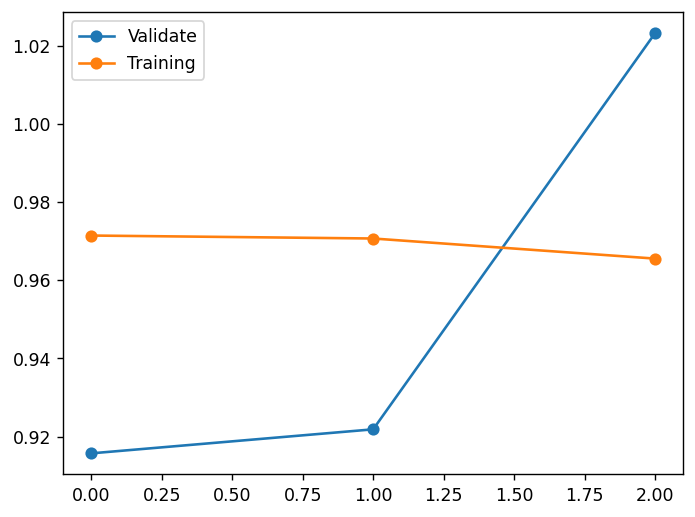

In [71]:
plt.figure(dpi=125)

plt.plot(range(len(cv_errors)), cv_errors, '-o', label="Validate")
plt.plot(range(len(cvtrain_errors)), cvtrain_errors, '-o', label="Training")
plt.legend()
plt.show()

In [72]:
trainmean

[0.9692010084788004]

In [73]:
valmean

[0.953567385673523]

In [74]:
linearmodel = ElasticNet()
fullreg = linearmodel.fit(nyX, nyY)

In [75]:
# plt.plot(range(ntesting), trainmean, label="training")
# plt.fill_between(
#     range(ntesting), 
#     np.array(trainmean) - np.array(trainstd), 
#     np.array(trainmean) + np.array(trainstd),
#     alpha=0.2
# ) 

# plt.plot(range(ntesting), valmean, label="validation")
# plt.fill_between(
#     range(ntesting), 
#     np.array(valmean) - np.array(valstd), 
#     np.array(valmean) + np.array(valstd),
#     alpha=0.2
# )

# plt.ylim(0.3, 1.3)
# plt.legend()
# plt.show()

In [76]:
# config['epochs'] = int(1e3)
# config['lr'] = 0.01

In [77]:
config

{'random_seed': 10,
 'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.15,
 'test_percent': 15,
 'building_buffer': 400,
 'building_buffer_min': 20,
 'building_buffer_max': 1000,
 'building_buffer_npoints': 5,
 'neighbor_radius': 100,
 'n_cv': 3,
 'n_cv_generalization': 2,
 'cv_size': 1179,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area']}

In [78]:
g1['footprint'].x

tensor([[-0.4549, -2.0671,  1.0189],
        [ 0.2831, -1.9562,  0.9940],
        [ 1.0018, -0.0931, -0.2042],
        ...,
        [-1.2981, -0.3616, -0.0488],
        [-1.6913,  0.2277, -0.2487],
        [-0.0284,  0.6208, -0.1038]], device='cuda:0')

In [79]:
g1['pano']

{'x': tensor([[ 0.3330,  2.0289, -0.7797, -0.6800],
        [-0.3146,  1.8190, -0.9223, -0.1217],
        [-0.1620,  2.0453, -0.7429, -0.6262],
        ...,
        [-2.4539, -1.2330, -2.0149, -0.6800],
        [ 0.7467, -1.2330, -1.1629, -0.6800],
        [ 0.4302, -1.2330, -0.8386,  3.0318]], device='cuda:0')}

In [80]:
# from collections import Counter
# sorted(Counter(g1a['footprints'].id).items(), key=lambda x:-x[1])

In [81]:
g1a['footprints']

,id,geometry,energy,area,year,hdd,cdd,logenergy
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485,6.929539
1,11640540857295396741,"POLYGON ((585824.204 4511010.579, 585801.557 4...",1976.070202,8779.345776,2012,1687.509132,5349.625418,7.588865
2,2176611449573922396,"POLYGON ((585546.811 4510715.429, 585530.747 4...",4025.883834,15241.408783,2012,2738.533604,4674.101243,8.300500
3,15634040336852848410,"POLYGON ((585476.710 4510964.643, 585463.466 4...",1698.343339,6851.234218,2012,1650.579136,5176.224177,7.437409
4,14406020392858049933,"POLYGON ((585796.868 4510668.833, 585753.012 4...",3524.173769,20209.961074,2012,2027.315521,5382.643972,8.167401
...,...,...,...,...,...,...,...,...
13867,15651345487193931624,"POLYGON ((590076.780 4509223.274, 589983.358 4...",436.916958,6038.703444,2012,1818.711056,5415.344122,6.079743
13868,17223719695729998017,"POLYGON ((589939.476 4509249.579, 589897.284 4...",419.785440,5852.897184,2012,1550.300903,5767.163863,6.039744
13869,12175045392502182871,"POLYGON ((592782.975 4507852.583, 592773.856 4...",127.623327,2608.069566,2017,2587.075502,4761.694998,4.849083
13870,14468115704619059393,"POLYGON ((594001.388 4507724.943, 593989.251 4...",178.697681,1928.668977,2016,2919.485011,4649.001118,5.185695


In [82]:
g1a['footprints'].drop(columns=["id","geometry","year"])

,energy,area,hdd,cdd,logenergy
0,1022.022331,4982.209051,1624.918473,5363.637485,6.929539
1,1976.070202,8779.345776,1687.509132,5349.625418,7.588865
2,4025.883834,15241.408783,2738.533604,4674.101243,8.300500
3,1698.343339,6851.234218,1650.579136,5176.224177,7.437409
4,3524.173769,20209.961074,2027.315521,5382.643972,8.167401
...,...,...,...,...,...
13867,436.916958,6038.703444,1818.711056,5415.344122,6.079743
13868,419.785440,5852.897184,1550.300903,5767.163863,6.039744
13869,127.623327,2608.069566,2587.075502,4761.694998,4.849083
13870,178.697681,1928.668977,2919.485011,4649.001118,5.185695


In [83]:
g1a['node_data_original'].columns

Index(['pano_id', 'pano_date', 'geometry', 'id', 'car_area', 'building_area',
       'truck_area', 'traffic light_area', 'person_area', 'road_area',
       'traffic sign_area', 'terrain_area', 'sky_area', 'wall_area',
       'fence_area', 'motorcycle_area', 'pole_area', 'bus_area',
       'vegetation_area', 'sidewalk_area', 'bicycle_area', 'train_area',
       'rider_area', 'car_count', 'building_count', 'bicycle_count',
       'person_count', 'road_count', 'traffic sign_count', 'sidewalk_count',
       'sky_count', 'fence_count', 'pole_count', 'vegetation_count',
       'motorcycle_count', 'truck_count', 'terrain_count', 'rider_count',
       'traffic light_count', 'wall_count', 'bus_count', 'train_count'],
      dtype='object')

In [84]:
g1a['footprints'].energy

0        1022.022331
1        1976.070202
2        4025.883834
3        1698.343339
4        3524.173769
            ...     
13867     436.916958
13868     419.785440
13869     127.623327
13870     178.697681
13871    2190.138580
Name: energy, Length: 13872, dtype: float64

In [85]:
config['input_shape'] = g1['footprint'].x.shape[1]

In [86]:
g1a['footprints']

,id,geometry,energy,area,year,hdd,cdd,logenergy
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485,6.929539
1,11640540857295396741,"POLYGON ((585824.204 4511010.579, 585801.557 4...",1976.070202,8779.345776,2012,1687.509132,5349.625418,7.588865
2,2176611449573922396,"POLYGON ((585546.811 4510715.429, 585530.747 4...",4025.883834,15241.408783,2012,2738.533604,4674.101243,8.300500
3,15634040336852848410,"POLYGON ((585476.710 4510964.643, 585463.466 4...",1698.343339,6851.234218,2012,1650.579136,5176.224177,7.437409
4,14406020392858049933,"POLYGON ((585796.868 4510668.833, 585753.012 4...",3524.173769,20209.961074,2012,2027.315521,5382.643972,8.167401
...,...,...,...,...,...,...,...,...
13867,15651345487193931624,"POLYGON ((590076.780 4509223.274, 589983.358 4...",436.916958,6038.703444,2012,1818.711056,5415.344122,6.079743
13868,17223719695729998017,"POLYGON ((589939.476 4509249.579, 589897.284 4...",419.785440,5852.897184,2012,1550.300903,5767.163863,6.039744
13869,12175045392502182871,"POLYGON ((592782.975 4507852.583, 592773.856 4...",127.623327,2608.069566,2017,2587.075502,4761.694998,4.849083
13870,14468115704619059393,"POLYGON ((594001.388 4507724.943, 593989.251 4...",178.697681,1928.668977,2016,2919.485011,4649.001118,5.185695


In [87]:
g1a['footprints']

,id,geometry,energy,area,year,hdd,cdd,logenergy
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485,6.929539
1,11640540857295396741,"POLYGON ((585824.204 4511010.579, 585801.557 4...",1976.070202,8779.345776,2012,1687.509132,5349.625418,7.588865
2,2176611449573922396,"POLYGON ((585546.811 4510715.429, 585530.747 4...",4025.883834,15241.408783,2012,2738.533604,4674.101243,8.300500
3,15634040336852848410,"POLYGON ((585476.710 4510964.643, 585463.466 4...",1698.343339,6851.234218,2012,1650.579136,5176.224177,7.437409
4,14406020392858049933,"POLYGON ((585796.868 4510668.833, 585753.012 4...",3524.173769,20209.961074,2012,2027.315521,5382.643972,8.167401
...,...,...,...,...,...,...,...,...
13867,15651345487193931624,"POLYGON ((590076.780 4509223.274, 589983.358 4...",436.916958,6038.703444,2012,1818.711056,5415.344122,6.079743
13868,17223719695729998017,"POLYGON ((589939.476 4509249.579, 589897.284 4...",419.785440,5852.897184,2012,1550.300903,5767.163863,6.039744
13869,12175045392502182871,"POLYGON ((592782.975 4507852.583, 592773.856 4...",127.623327,2608.069566,2017,2587.075502,4761.694998,4.849083
13870,14468115704619059393,"POLYGON ((594001.388 4507724.943, 593989.251 4...",178.697681,1928.668977,2016,2919.485011,4649.001118,5.185695


In [88]:
g1['footprint']

{'x': tensor([[-0.4549, -2.0671,  1.0189],
        [ 0.2831, -1.9562,  0.9940],
        [ 1.0018, -0.0931, -0.2042],
        ...,
        [-1.2981, -0.3616, -0.0488],
        [-1.6913,  0.2277, -0.2487],
        [-0.0284,  0.6208, -0.1038]], device='cuda:0'), 'y': tensor([6.9295, 7.5889, 8.3005,  ..., 4.8491, 5.1857, 7.6917], device='cuda:0'), 'train_mask': tensor([True, True, True,  ..., True, True, True], device='cuda:0'), 'test_mask': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}

In [89]:
# input_shape = nycgraph['footprint'].x.shape[1]
seed_everything(rand)

nullmodel = NullModel(
    layers = config['linear_layers'],
    input_shape = config['input_shape'],
    hidden_channels = config['hidden_channels']
).to(device)

default_nullmodelstate = copy.deepcopy(nullmodel.state_dict())
null_training_tensor, null_validation_tensor = crossvalidation(
    nullmodel,
    lambda: nullmodel(g1['footprint'].x),
    nyc_cvs,
    g1['footprint'].y,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

CV Loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

In [90]:
model = CustomGAT(
    hidden_channels = config['hidden_channels'], 
    out_channels=config['graph_outchannels'],
    layers=config['graph_layers'],
    heads=config['graph_heads'],
    linear_layers = config['linear_layers'],
    input_shape = config['input_shape'],
    dropout = config['dropout']
).to(device)

default_modelstate = copy.deepcopy(model.state_dict())

/home/thomas/miniconda3/envs/dbr/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:58: UserWarning: There exist node types ({'pano'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


In [91]:
loss_func

MSELoss()

In [92]:
seed_everything(rand)
graph_training_tensor, graph_validation_tensor = crossvalidation(
    model,
    lambda: model(g1.x_dict, g1.edge_index_dict),
    nyc_cvs,
    g1['footprint'].y,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    loss_func = loss_func,
    log_model = False
)

CV Loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

In [93]:
g1a['footprints'].describe()

,energy,area,year,hdd,cdd,logenergy
count,1.387200e+04,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000
mean,9.245888e+03,9624.112161,2014.149438,2791.043777,4789.228452,7.454696
std,1.203647e+05,8808.004385,2.312903,564.135391,563.774230,1.077664
min,3.597384e-01,27.870939,2012.000000,185.345664,2183.403795,-1.022378
25%,1.026889e+03,4145.012495,2012.000000,2498.719080,4426.372498,6.934289
50%,1.649080e+03,6503.219093,2012.000000,2920.930778,4794.381970,7.407973
75%,2.826627e+03,11391.572757,2017.000000,3178.775336,5157.361963,7.946839
max,5.376747e+06,50304.071944,2017.000000,4149.092892,7588.287268,15.497594


In [94]:
# g1a['footprints'].explore('energy', control_scale=True)

In [95]:
null_mean_tl = null_training_tensor.mean(axis=0)
null_mean_vl = null_validation_tensor.mean(axis=0)
nulllower_vl = np.percentile(null_validation_tensor, 5, axis=0)
nullupper_vl = np.percentile(null_validation_tensor, 95, axis=0)

In [96]:
mean_tl = graph_training_tensor.mean(axis=0)
std_tl = graph_training_tensor.std(axis=0)

mean_vl = graph_validation_tensor.mean(axis=0)
lower_vl = np.percentile(graph_validation_tensor, 5, axis=0)
upper_vl = np.percentile(graph_validation_tensor, 95, axis=0)
std_vl = graph_validation_tensor.std(axis=0)

# plt.plot(mean_tl, label="Graph Training")
# plt.plot(mean_vl, label="Graph Validation")
# plt.legend()

# plt.yscale("log")
# plt.ylim((0.55,0.65))

# plt.show()

In [97]:
mean_vl[:5]

array([34.289577, 20.585966, 17.794737, 17.5683  , 17.638086],
      dtype=float32)

In [98]:
graph_epochs = np.argmin(mean_vl)
deepl_epochs = np.argmin(null_mean_vl)

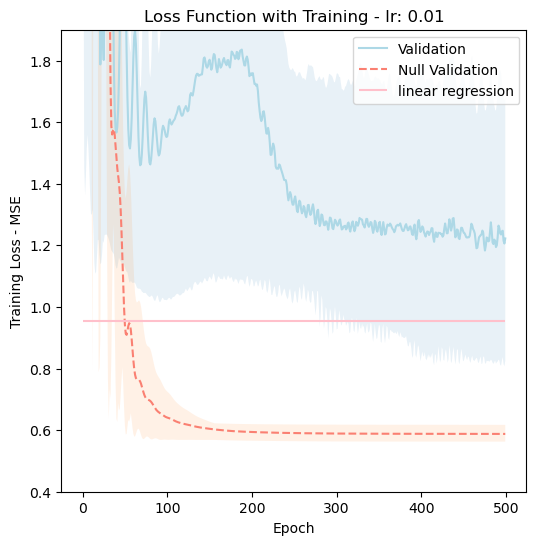

In [99]:
domain = np.arange(0, config['epochs'])
plt.figure(figsize=(6, 6), dpi=100)

# plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
plt.fill_between(domain, upper_vl, lower_vl, alpha=0.1)

# plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')
plt.fill_between(domain, nullupper_vl, nulllower_vl, alpha=0.1)

plt.hlines(valmean[0], min(domain), max(domain), color='pink', label="linear regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

# plt.yscale("log")
plt.ylim((0.4,1.9))

plt.savefig(os.path.join(results_dir, 'model_comparison.png'), bbox_inches="tight")
plt.show()

In [100]:
graph_improvement = (min(mean_vl) - min(null_mean_vl)) / min(null_mean_vl)
print("Improvement from Context: {:0.2f}%".format(100*graph_improvement))

Improvement from Context: 101.34%


In [101]:
np.min(mean_vl)

1.1831871

In [102]:
np.percentile(mean_vl, 5)

1.2253936231136322

In [103]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "w")
f.write(str("New York City Profile:\n"))
f.write(str("Min CV Loss:\t{:.4f}\n".format(np.min(mean_vl))))
f.write(str("5th P CV Loss:\t{:.4f}\n".format(np.percentile(mean_vl, 5))))
f.write(str("25th P CV Loss:\t{:.4f}\n\n".format(np.percentile(mean_vl, 25))))
f.close()

In [104]:
## In understanding how the model generalizes, we look at the lowest validation systems
nullmodel.load_state_dict(default_nullmodelstate)
nullmodel.to(device)
nullmodel.train()
    
model.load_state_dict(default_modelstate)
model.to(device)
model.train()

null_training_tensor, null_validation_tensor = crossvalidation(
    nullmodel,
    lambda: nullmodel(g1['footprint'].x),
    [nyc_cvs[0]],
    g1['footprint'].y,
    epochs = deepl_epochs,
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

graph_training_tensor, graph_validation_tensor = crossvalidation(
    model,
    lambda: model(g1.x_dict, g1.edge_index_dict),
    [nyc_cvs[0]],
    g1['footprint'].y,
    epochs = graph_epochs,
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

CV Loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/499 [00:00<?, ?it/s]

CV Loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/475 [00:00<?, ?it/s]

In [105]:
# now examining how this may generalize
model.eval()
nullmodel.eval()
with torch.no_grad():
    print("New York City")
    testidx = (~g1a['training_mask']).detach().cpu().numpy()
    # rebuilding_idx = np.array(g1a['rebuild_idx'])

    linear_predictions = reg.predict(g1['footprint'].x.cpu().numpy())[testidx]
    null_predictions = nullmodel(g1['footprint'].x).squeeze()[testidx]
    estimates = model(g1.x_dict, g1.edge_index_dict).squeeze().detach()[testidx]
    recorded = g1['footprint'].y[testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    
    print("Linear Loss:\t{:0.3f}".format(linear_loss))
    print("Null Loss:\t{:0.3f}".format(null_loss))
    print("Graph Loss:\t{:0.3f}".format(graph_loss))
    print("Improvement:\t{:0.3f}".format(100 * (graph_loss - null_loss)/null_loss))

New York City
Linear Loss:	0.892
Null Loss:	0.550
Graph Loss:	0.819
Improvement:	48.987


In [106]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("New York City Test Set Results:\n"))

f.write(("Linear Loss:\t{:0.3f}\n".format(linear_loss)))
f.write(("Null Loss:\t\t{:0.3f}\n".format(null_loss)))
f.write(("Graph Loss:\t\t{:0.3f}\n".format(graph_loss)))
f.write(("Percent Ben:\t{:0.3f}\n\n".format(100 * (graph_loss - null_loss)/null_loss)))

f.close()

In [107]:
linmae = torch.abs(torch.exp(recorded) - torch.tensor(np.exp(linear_predictions)).to(device))
nullmae = torch.abs(torch.exp(recorded) - torch.exp(null_predictions))
graphmae = torch.abs(torch.exp(recorded) - torch.exp(estimates))

In [108]:
def relative_benefit(errors, threshold):
    return float(100 * ((errors <= threshold).sum() / len(errors)))

In [109]:
### want to get a curve to show accuracy with various buffers
linmae_list = []
nullmae_list = []
graphmae_list = []

maxlenlist = 2000

for i in range(maxlenlist):
    linmae_list.append(relative_benefit(linmae, i))
    nullmae_list.append(relative_benefit(nullmae, i))
    graphmae_list.append(relative_benefit(graphmae, i))

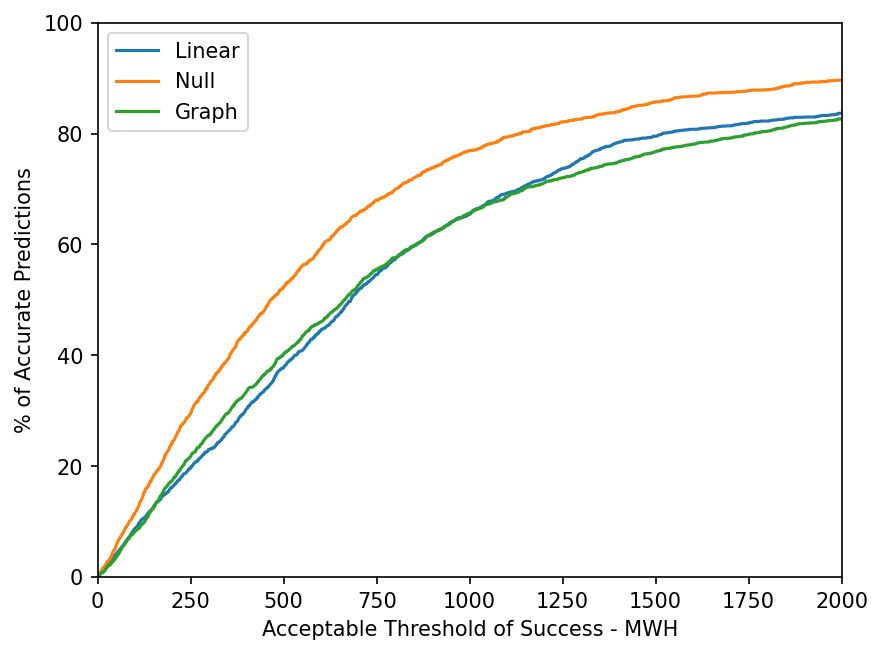

In [110]:
plt.figure(dpi=150)

plt.plot(range(maxlenlist), linmae_list, label="Linear")
plt.plot(range(maxlenlist), nullmae_list, label="Null")
plt.plot(range(maxlenlist), graphmae_list, label="Graph")

# plt.yscale("log")
plt.ylim(0,100)
plt.xlim(0,maxlenlist)

plt.xlabel("Acceptable Threshold of Success - MWH")
plt.ylabel("% of Accurate Predictions")

plt.legend()

plt.savefig(os.path.join(results_dir, "accurate_predictions_nyc.png"), transparent=True, bbox_inches="tight")

plt.show()

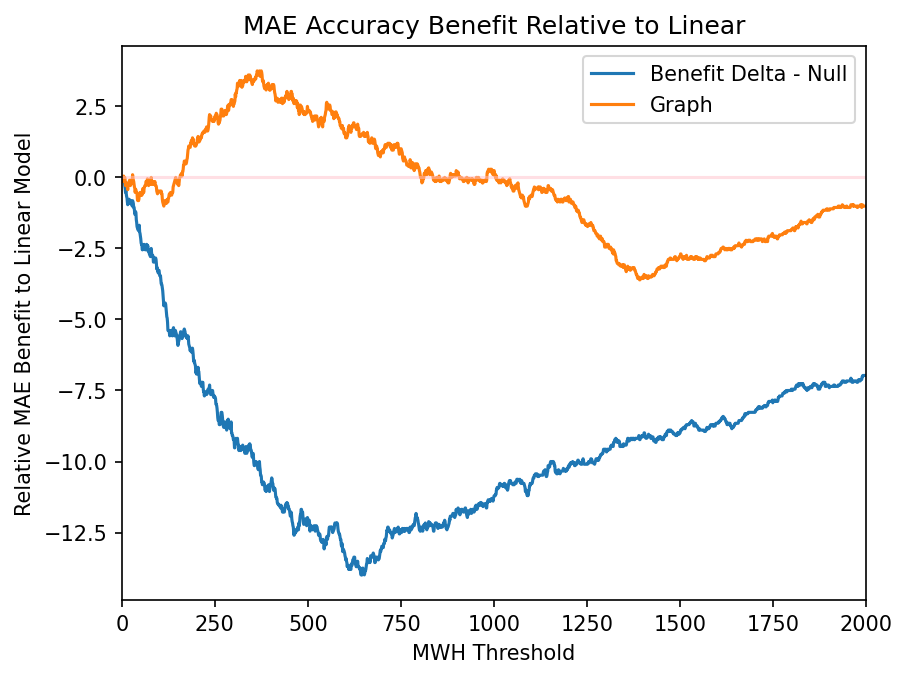

In [111]:
plt.figure(dpi=150)

plt.plot(range(maxlenlist), np.array(graphmae_list) - np.array(nullmae_list), '-', label="Benefit Delta - Null")
plt.plot(range(maxlenlist), np.array(graphmae_list) - np.array(linmae_list), '-', label="Graph")

plt.hlines(0, xmin = 0, xmax = maxlenlist, color="pink", alpha=0.5)

# plt.yscale("log")
# plt.ylim(0,20)
plt.xlim(0,maxlenlist)

plt.ylabel("Relative MAE Benefit to Linear Model")
plt.xlabel("MWH Threshold")

plt.title("MAE Accuracy Benefit Relative to Linear")
plt.savefig(os.path.join(results_dir, "relative_benefit.png"), transparent=True, bbox_inches="tight")
plt.legend()

plt.show()

In [112]:
threshold = 500

print(f"Linear Benefit:\t\t{relative_benefit(linmae, threshold):0.2f}")
print(f"Null Benefit:\t\t{relative_benefit(nullmae, threshold):0.2f}")
print(f"Graph Benefit:\t\t{relative_benefit(graphmae, threshold):0.2f}")

Linear Benefit:		37.84
Null Benefit:		52.26
Graph Benefit:		40.24


In [113]:
## first want to load each of the models which will be trained on the entire dataset from the other city
nullmodel.load_state_dict(default_nullmodelstate)
nullmodel.to(device)
nullmodel.train()
    
model.load_state_dict(default_modelstate)
model.to(device)
model.train()

nulloptimizer = torch.optim.Adam(nullmodel.parameters(), lr = config['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])

# maybe I want to take the 5th percentile of minimum validation loss actually
set_epochs = config['epochs']

for epoch in tqdm_notebook(range(set_epochs), desc="Model Epoch", leave=False):
    loss = 0
    validation_loss = 0

    out = model(g1.x_dict, g1.edge_index_dict)
    out_ex = out.squeeze()

    training_predictions = out_ex.to(torch.float).to(device)
    training_values = torch.tensor(g1a['footprints'].logenergy).to(torch.float).to(device)

    loss = loss_func(
        training_predictions,
        training_values
    ).to(torch.float)
    
    if epoch % 100 == 0:
        print("{} loss: {}".format(epoch, loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("")
for epoch in tqdm_notebook(range(set_epochs), desc="NullModel Epoch", leave=False):
    loss = 0
    validation_loss = 0

    out = nullmodel(g1['footprint'].x)
    out_ex = out.squeeze()

    training_predictions = out_ex.to(torch.float).to(device)
    training_values = torch.tensor(g1a['footprints'].logenergy).to(torch.float).to(device)

    loss = loss_func(
        training_predictions,
        training_values
    ).to(torch.float)
    
    if epoch % 100 == 0:
        print("{} loss: {}".format(epoch, loss))

    nulloptimizer.zero_grad()
    loss.backward()
    nulloptimizer.step()
    
nystate_dict = model.state_dict()
nullnystate_dict = nullmodel.state_dict()

/tmp/ipykernel_41183/636389068.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(set_epochs), desc="Model Epoch", leave=False):


Model Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

0 loss: 52.055747985839844
100 loss: 3.825420379638672
200 loss: 3.173431634902954
300 loss: 2.518249988555908
400 loss: 2.150432586669922



/tmp/ipykernel_41183/636389068.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(set_epochs), desc="NullModel Epoch", leave=False):


NullModel Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

0 loss: 56.48048400878906
100 loss: 0.7933843731880188
200 loss: 0.6290509700775146
300 loss: 0.6112900972366333
400 loss: 0.6080897450447083


In [114]:
# now examining how this may generalize
model.load_state_dict(nystate_dict)
model.to(device)

nullmodel.load_state_dict(nullnystate_dict)
nullmodel.to(device)

model.eval()
nullmodel.eval()

with torch.no_grad():
    print("San Francisco")
    testidx = (~g2a['training_mask']).detach().cpu().numpy()
    rebuilding_idx = np.array(g2a['rebuild_idx'])
    null_predictions = nullmodel(g2['footprint'].x).squeeze()[testidx]
    
    linear_predictions = reg.predict(g2['footprint'].x.cpu().numpy())[testidx]
    estimates = model(g2.x_dict, g2.edge_index_dict).squeeze().detach()[testidx]
    recorded = g2['footprint'].y[testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

San Francisco
Linear Loss:	2.22
Null Loss:	2.91
Graph Loss:	1.46
Improvement:	-49.75


In [115]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("San Francisco Test Set Results - No Finetuning:\n"))

f.write(("Linear Loss:\t{:0.3f}\n".format(linear_loss)))
f.write(("Null Loss:\t\t{:0.3f}\n".format(null_loss)))
f.write(("Graph Loss:\t\t{:0.3f}\n".format(graph_loss)))
f.write(("Percent Ben:\t{:0.3f}\n\n".format(100 * (graph_loss - null_loss)/null_loss)))

f.close()

In [116]:
model.load_state_dict(nystate_dict)
model.to(device)

nullmodel.load_state_dict(nullnystate_dict)
nullmodel.to(device)

nullmodel.eval()
model.eval()
with torch.no_grad():
    print("Austin Texas")
    testidx = (~g3a['training_mask']).detach().cpu().numpy()
    rebuilding_idx = np.array(g3a['rebuild_idx'])
    null_predictions = nullmodel(g3['footprint'].x).squeeze()[testidx]
    
    linear_predictions = reg.predict(g3['footprint'].x.cpu().numpy())[testidx]
    
    estimates = model(g3.x_dict, g3.edge_index_dict).squeeze().detach()[testidx]
    recorded = g3['footprint'].y[testidx]
    
    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

Austin Texas
Linear Loss:	8.02
Null Loss:	17.11
Graph Loss:	5.79
Improvement:	-66.17


In [117]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("Austin Test Set Results - No Finetuning:\n"))

f.write(("Linear Loss:\t{:0.3f}\n".format(linear_loss)))
f.write(("Null Loss:\t\t{:0.3f}\n".format(null_loss)))
f.write(("Graph Loss:\t\t{:0.3f}\n".format(graph_loss)))
f.write(("Percent Ben:\t{:0.3f}\n\n".format(100 * (graph_loss - null_loss)/null_loss)))

f.close()

In [118]:
tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)
# tcorp

In [119]:
RandomForestRegressor(max_depth=3, random_state=rand)

RandomForestRegressor(max_depth=3, random_state=10)

In [120]:
g1, g1a = graph("new-york", **{**config, **{"building_buffer":config['building_buffer_min']}})
trainids, testids = build_corpus(g1, g1a)

In [121]:
pd.util.hash_pandas_object(tcorp.id).sum()

-4679655695588624710

In [122]:
tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)

In [123]:
m1_terms = ["id","geometry","energy","year","area"]
tcorp[m1_terms]

,id,geometry,energy,year,area
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,2012,4982.209051
1,10426804091157841868,"POLYGON ((585927.840 4510967.054, 585913.878 4...",7476.661849,2012,43841.823131
2,13984590206613124140,"POLYGON ((587451.332 4512457.088, 587424.453 4...",375055.715748,2012,7460.121331
3,18069133829578216584,"POLYGON ((587479.460 4512496.111, 587446.628 4...",1054.787223,2012,9754.828640
4,3936784749187828781,"POLYGON ((587445.747 4512512.119, 587423.893 4...",1551.129944,2012,8602.179507
...,...,...,...,...,...
12793,12618438599830320340,"POLYGON ((592296.077 4509139.097, 592238.791 4...",1382.376267,2012,8915.263055
12794,5493187043257100533,"POLYGON ((588931.564 4517977.890, 588891.523 4...",6265.973495,2012,25350.105445
12795,15242956676492688919,"POLYGON ((587808.975 4516068.062, 587741.570 4...",784.407552,2016,1207.740689
12796,7395414680666969706,"POLYGON ((583950.549 4509920.789, 583949.374 4...",298.200742,2017,3496.688003


In [124]:
distances

array([  20.,  265.,  510.,  755., 1000.])

In [125]:
# # starting graph, which defines the test and train ids
# g1, g1a = graph("new-york", **{**config, **{"building_buffer":config['building_buffer_min']}})
# trainids, testids = build_corpus(g1, g1a)

# trainings = []

# for distance in tqdm_notebook(distances[:6]):
#     print(f"Distance: {distance:.2f}")
#     g1, g1a = graph("new-york", **{**config, **{"building_buffer":distance}})
#     tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)
#     # print(tcorp.id.isin(trainids[0]))
#     training = tcorp.loc[tcorp.id.isin(trainids[0])]
#     trainings.append(training)

In [126]:
## this is now the segment where we explore the utility of various datasets with increasing distance from the model
m1a = []
m2a = []
m3a = []
m4a = []
m5a = []
m6a = []

m1l = []
m2l = []
m3l = []
m4l = []
m5l = []
m6l = []

linearmodel = ElasticNet()
tree = RandomForestRegressor(max_depth = 6, min_samples_leaf = 4, n_estimators = 64, random_state = rand, n_jobs = -1)

# starting graph, which defines the test and train ids
g1_base, g1a_base = graph("new-york", **{**config, **{"building_buffer":config['building_buffer_min']}})
trainids, testids = build_corpus(g1_base, g1a_base)

for distance in tqdm_notebook(distances):
    g1c, g1ac = graph("new-york", **{**config, **{"building_buffer":distance}})
    tcorp = pool_adjacency(g1c, g1ac).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    m1a.append(m1_mae)
    m1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    m2a.append(m2_mae)
    m2l.append(m2_rmse)

    m3_terms = m2_terms + config['partition_terms'] + [ x+'_max' for x in config['partition_terms']] + [ x+'_min' for x in config['partition_terms'] ]
    losses, abslosses = custom_cv(linearmodel, tcorp[m3_terms], trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    m3a.append(m3_mae)
    m3l.append(m3_rmse)

    m4_terms = m1_terms
    losses, abslosses = custom_cv(tree, tcorp[m4_terms], trainids, testids)
    m4_rmse = np.mean(losses)
    m4_mae = np.mean(abslosses)
    m4a.append(m4_mae)
    m4l.append(m4_rmse)

    m5_terms = m2_terms
    losserandom_state, abslosses = custom_cv(tree, tcorp[m5_terms], trainids, testids)
    m5_rmse = np.mean(losses)
    m5_mae = np.mean(abslosses)
    m5a.append(m5_mae)
    m5l.append(m5_rmse)

    m6_terms = m3_terms
    losses, abslosses = custom_cv(tree, tcorp[m6_terms], trainids, testids)
    m6_rmse = np.mean(losses)
    m6_mae = np.mean(abslosses)
    m6a.append(m6_mae)
    m6l.append(m6_rmse)

/tmp/ipykernel_41183/1264872760.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for distance in tqdm_notebook(distances):


  0%|          | 0/5 [00:00<?, ?it/s]

In [127]:
n4a = []
n5a = []
n6a = []

n4l = []
n5l = []
n6l = []

# starting graph, which defines the test and train ids
g2_base, g2a_base = graph("san-francisco", **{**config, **{"building_buffer":config['building_buffer_min']}})
trainids, testids = build_corpus(g2_base, g2a_base)

for distance in tqdm_notebook(distances):
    g2c, g2ac = graph("san-francisco", **{**config, **{"building_buffer":distance}})
    tcorp = pool_adjacency(g2c, g2ac).reset_index(drop=True)
    
    m4_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(tree, tcorp[m4_terms], trainids, testids)
    m4_rmse = np.mean(losses)
    m4_mae = np.mean(abslosses)
    n4a.append(m4_mae)
    n4l.append(m4_rmse)

    m5_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(tree, tcorp[m5_terms], trainids, testids)
    m5_rmse = np.mean(losses)
    m5_mae = np.mean(abslosses)
    n5a.append(m5_mae)
    n5l.append(m5_rmse)

    m6_terms = m5_terms + config['partition_terms'] + [ x+'_max' for x in config['partition_terms']] + [ x+'_min' for x in config['partition_terms'] ]
    losses, abslosses = custom_cv(tree, tcorp[m6_terms], trainids, testids)
    m6_rmse = np.mean(losses)
    m6_mae = np.mean(abslosses)
    n6a.append(m6_mae)
    n6l.append(m6_rmse)

/tmp/ipykernel_41183/1905221026.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for distance in tqdm_notebook(distances):


  0%|          | 0/5 [00:00<?, ?it/s]

In [128]:
linearmodel

ElasticNet()

In [129]:
o4a = []
o5a = []
o6a = []

o4l = []
o5l = []
o6l = []

# starting graph, which defines the test and train ids
g3_base, g3a_base = graph("austin", **{**config, **{"building_buffer":config['building_buffer_min']}})
trainids, testids = build_corpus(g3_base, g3a_base)

for distance in tqdm_notebook(distances):
    g3c, g3ac = graph("austin", **{**config, **{"building_buffer":distance}})
    tcorp = pool_adjacency(g3c, g3ac).reset_index(drop=True)
    
    m4_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(tree, tcorp[m1_terms], trainids, testids)
    m4_rmse = np.mean(losses)
    m4_mae = np.mean(abslosses)
    o4a.append(m4_mae)
    o4l.append(m4_rmse)

    m5_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(tree, tcorp[m5_terms], trainids, testids)
    m5_rmse = np.mean(losses)
    m5_mae = np.mean(abslosses)
    o5a.append(m5_mae)
    o5l.append(m5_rmse)

    m6_terms = m5_terms + config['partition_terms'] + [ x+'_max' for x in config['partition_terms']] + [ x+'_min' for x in config['partition_terms'] ]
    losses, abslosses = custom_cv(tree, tcorp[m6_terms], trainids, testids)
    m6_rmse = np.mean(losses)
    m6_mae = np.mean(abslosses)
    o6a.append(m6_mae)
    o6l.append(m6_rmse)

/tmp/ipykernel_41183/1939255083.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for distance in tqdm_notebook(distances):


  0%|          | 0/5 [00:00<?, ?it/s]

In [130]:
def parabola(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

In [131]:
fit_params, pcov = scipy.optimize.curve_fit(parabola, distances, m3l)
y_fit = parabola(distances, *fit_params)

In [132]:
config

{'random_seed': 10,
 'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.15,
 'test_percent': 15,
 'building_buffer': 400,
 'building_buffer_min': 20,
 'building_buffer_max': 1000,
 'building_buffer_npoints': 5,
 'neighbor_radius': 100,
 'n_cv': 3,
 'n_cv_generalization': 2,
 'cv_size': 1179,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area'],
 'input_shape': 3}

In [133]:
g3a_base.keys()

dict_keys(['rebuild_idx', 'node_data', 'node_data_original', 'footprints', 'training_mask', 'test_mask', 'normalization'])

In [134]:
g3a_base['footprints'].energy.mean()

125.74446438596492

In [135]:
g1a_base['footprints'].energy.mean()

9342.336719886509

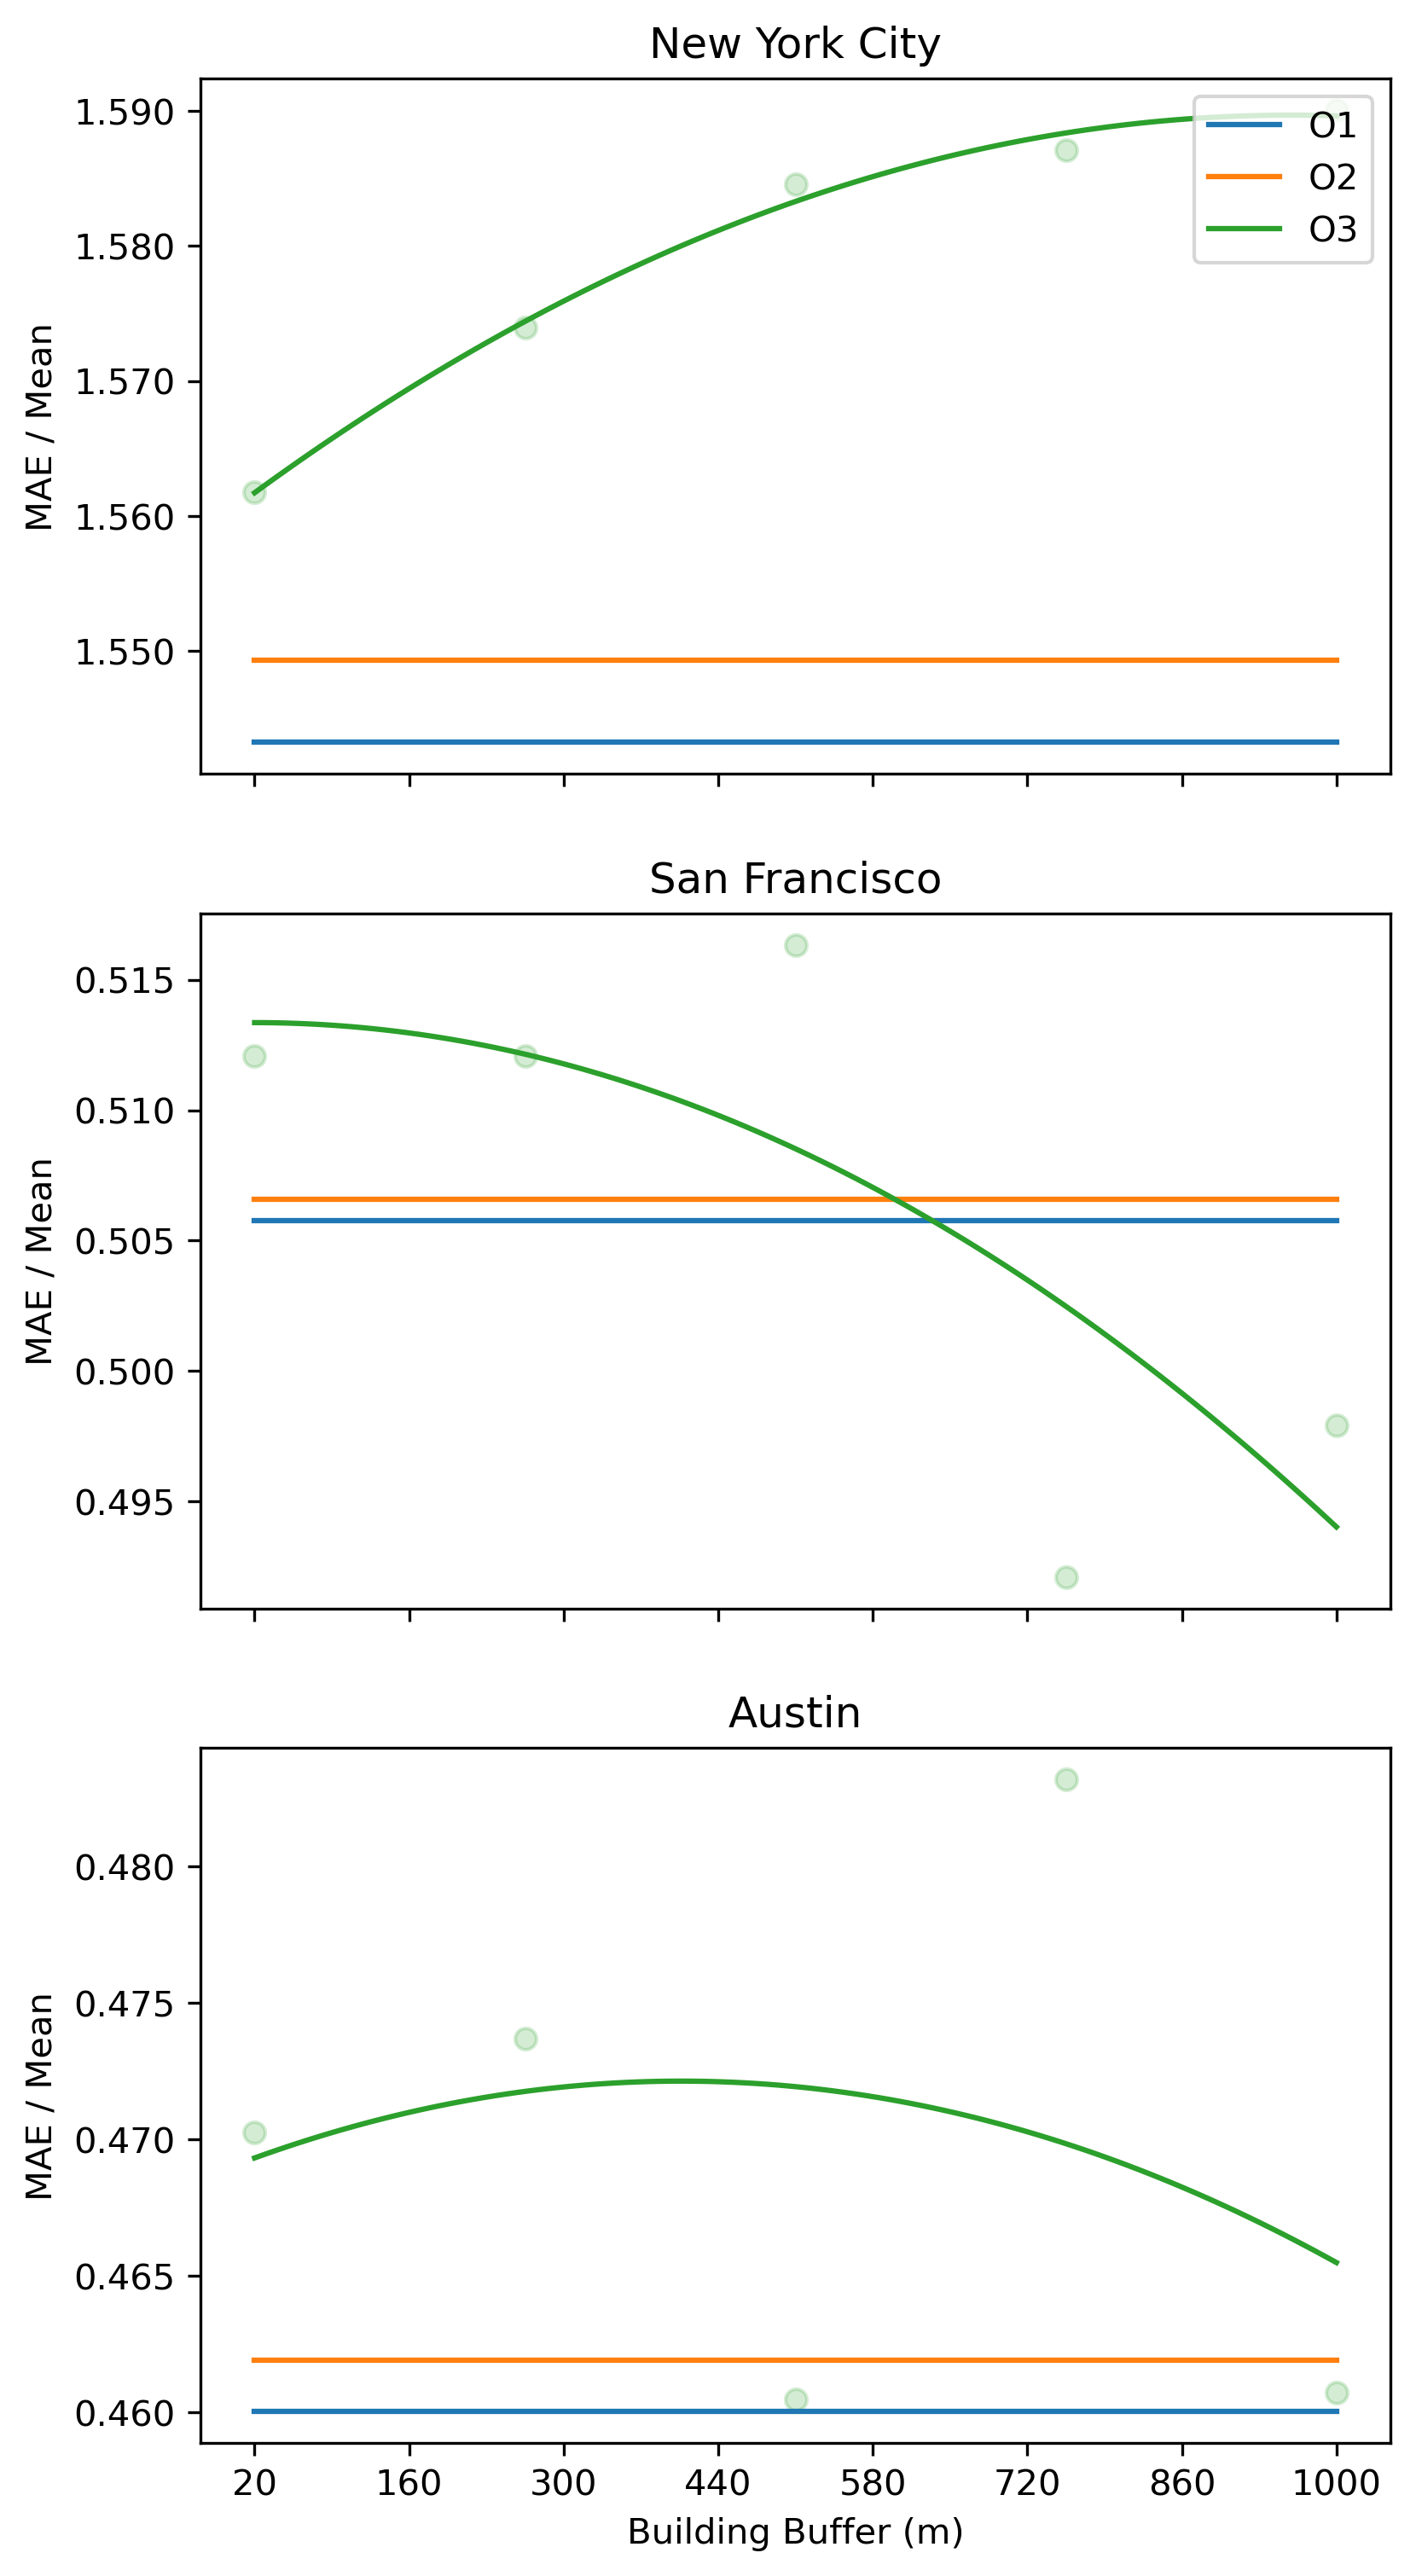

In [136]:
# plt.scatter(training_corpus
s = 0.0001
# m1s = splrep(distances, np.array(m1l), s=s)
# m2s = splrep(distances, np.array(m2l), s=s)
# m3s = splrep(distances, np.array(m3l), s=s)
# m4s = splrep(distances, np.array(m4l), s=s)
# m5s = splrep(distances, np.array(m5l), s=s)
# m6s = splrep(distances, np.array(m6l), s=s)
# Create subplots with shared x-axis

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(6,12))
fig.patch.set_facecolor('white')

ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')

# ax.set_color_cycle(sns.color_palette("coolwarm_r",6))

alpha = 0.2

# plt.scatter(distances, m4l, alpha=alpha)
# plt.scatter(distances, m5l, alpha=alpha)
# plt.scatter(distances, m6l, alpha=alpha)

newdist = np.linspace(distances[0], distances[-1], 100)

z6 = np.polyfit(distances, m6a / g1a_base['footprints'].energy.mean() ,2)
p6 = np.poly1d(z6)

ax1.set_title("Building Buffer vs. RMSE - New York City")
ax1.scatter(distances, m4a / g1a_base['footprints'].energy.mean(), alpha=0)
ax1.scatter(distances, m5a / g1a_base['footprints'].energy.mean(), alpha=0)
ax1.scatter(distances, m6a / g1a_base['footprints'].energy.mean(), alpha=alpha)

ax1.plot(newdist, csaps(distances, m4a / g1a_base['footprints'].energy.mean(), newdist, smooth=s), label="O1")
ax1.plot(newdist, csaps(distances, m5a /g1a_base['footprints'].energy.mean(), newdist, smooth=s), label="O2")
ax1.plot(newdist, p6(newdist), label="O3")

ax1.set_ylabel('MAE / Mean')

ax2.scatter(distances, n4a / g2a_base['footprints'].energy.mean(), alpha=0)
ax2.scatter(distances, n5a / g2a_base['footprints'].energy.mean(), alpha=0)
ax2.scatter(distances, n6a / g2a_base['footprints'].energy.mean(), alpha=alpha)


z6n = np.polyfit(distances, n6a / g2a_base['footprints'].energy.mean(),2)
p6n = np.poly1d(z6n)

ax2.plot(newdist, csaps(distances, n4a / g2a_base['footprints'].energy.mean(), newdist, smooth=s), label="O1")
ax2.plot(newdist, csaps(distances, n5a / g2a_base['footprints'].energy.mean(), newdist, smooth=s), label="O2")
ax2.plot(newdist, p6n(newdist), label="O3")

ax2.set_ylabel('MAE / Mean')

ax3.scatter(distances, o4a / g3a_base['footprints'].energy.mean(), alpha=0)
ax3.scatter(distances, o5a / g3a_base['footprints'].energy.mean(), alpha=0)
ax3.scatter(distances, o6a / g3a_base['footprints'].energy.mean(), alpha=alpha)

z6o = np.polyfit(distances, o6a / g3a_base['footprints'].energy.mean(),2)
p6o = np.poly1d(z6o)

ax3.plot(newdist, csaps(distances, o4a / g3a_base['footprints'].energy.mean(), newdist, smooth=s), label="O1")
ax3.plot(newdist, csaps(distances, o5a / g3a_base['footprints'].energy.mean(), newdist, smooth=s), label="O2")
ax3.plot(newdist, p6o(newdist), label="O3")

ax3.set_ylabel('MAE / Mean')

# plt.plot(newdist, csaps(distances, m4l, newdist, smooth=s), label="M4")
# plt.plot(newdist, csaps(distances, m5l, newdist, smooth=s), label="M5")
# plt.plot(newdist, csaps(distances, m6l, newdist, smooth=s), label="M6")

ax3.set_xlabel("Building Buffer (m)")

# plt.title("Building Buffer vs. RMSE - New York City")
# plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.xticks(np.linspace(distances.min(), distances.max(), 8))

ax1.legend(loc="upper right")

ax1.set_title('New York City')
ax2.set_title('San Francisco')
ax3.set_title('Austin')

ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f')) 

plt.savefig(os.path.join(results_dir, "contextual_significance.png"), transparent=True, bbox_inches="tight")
plt.show()

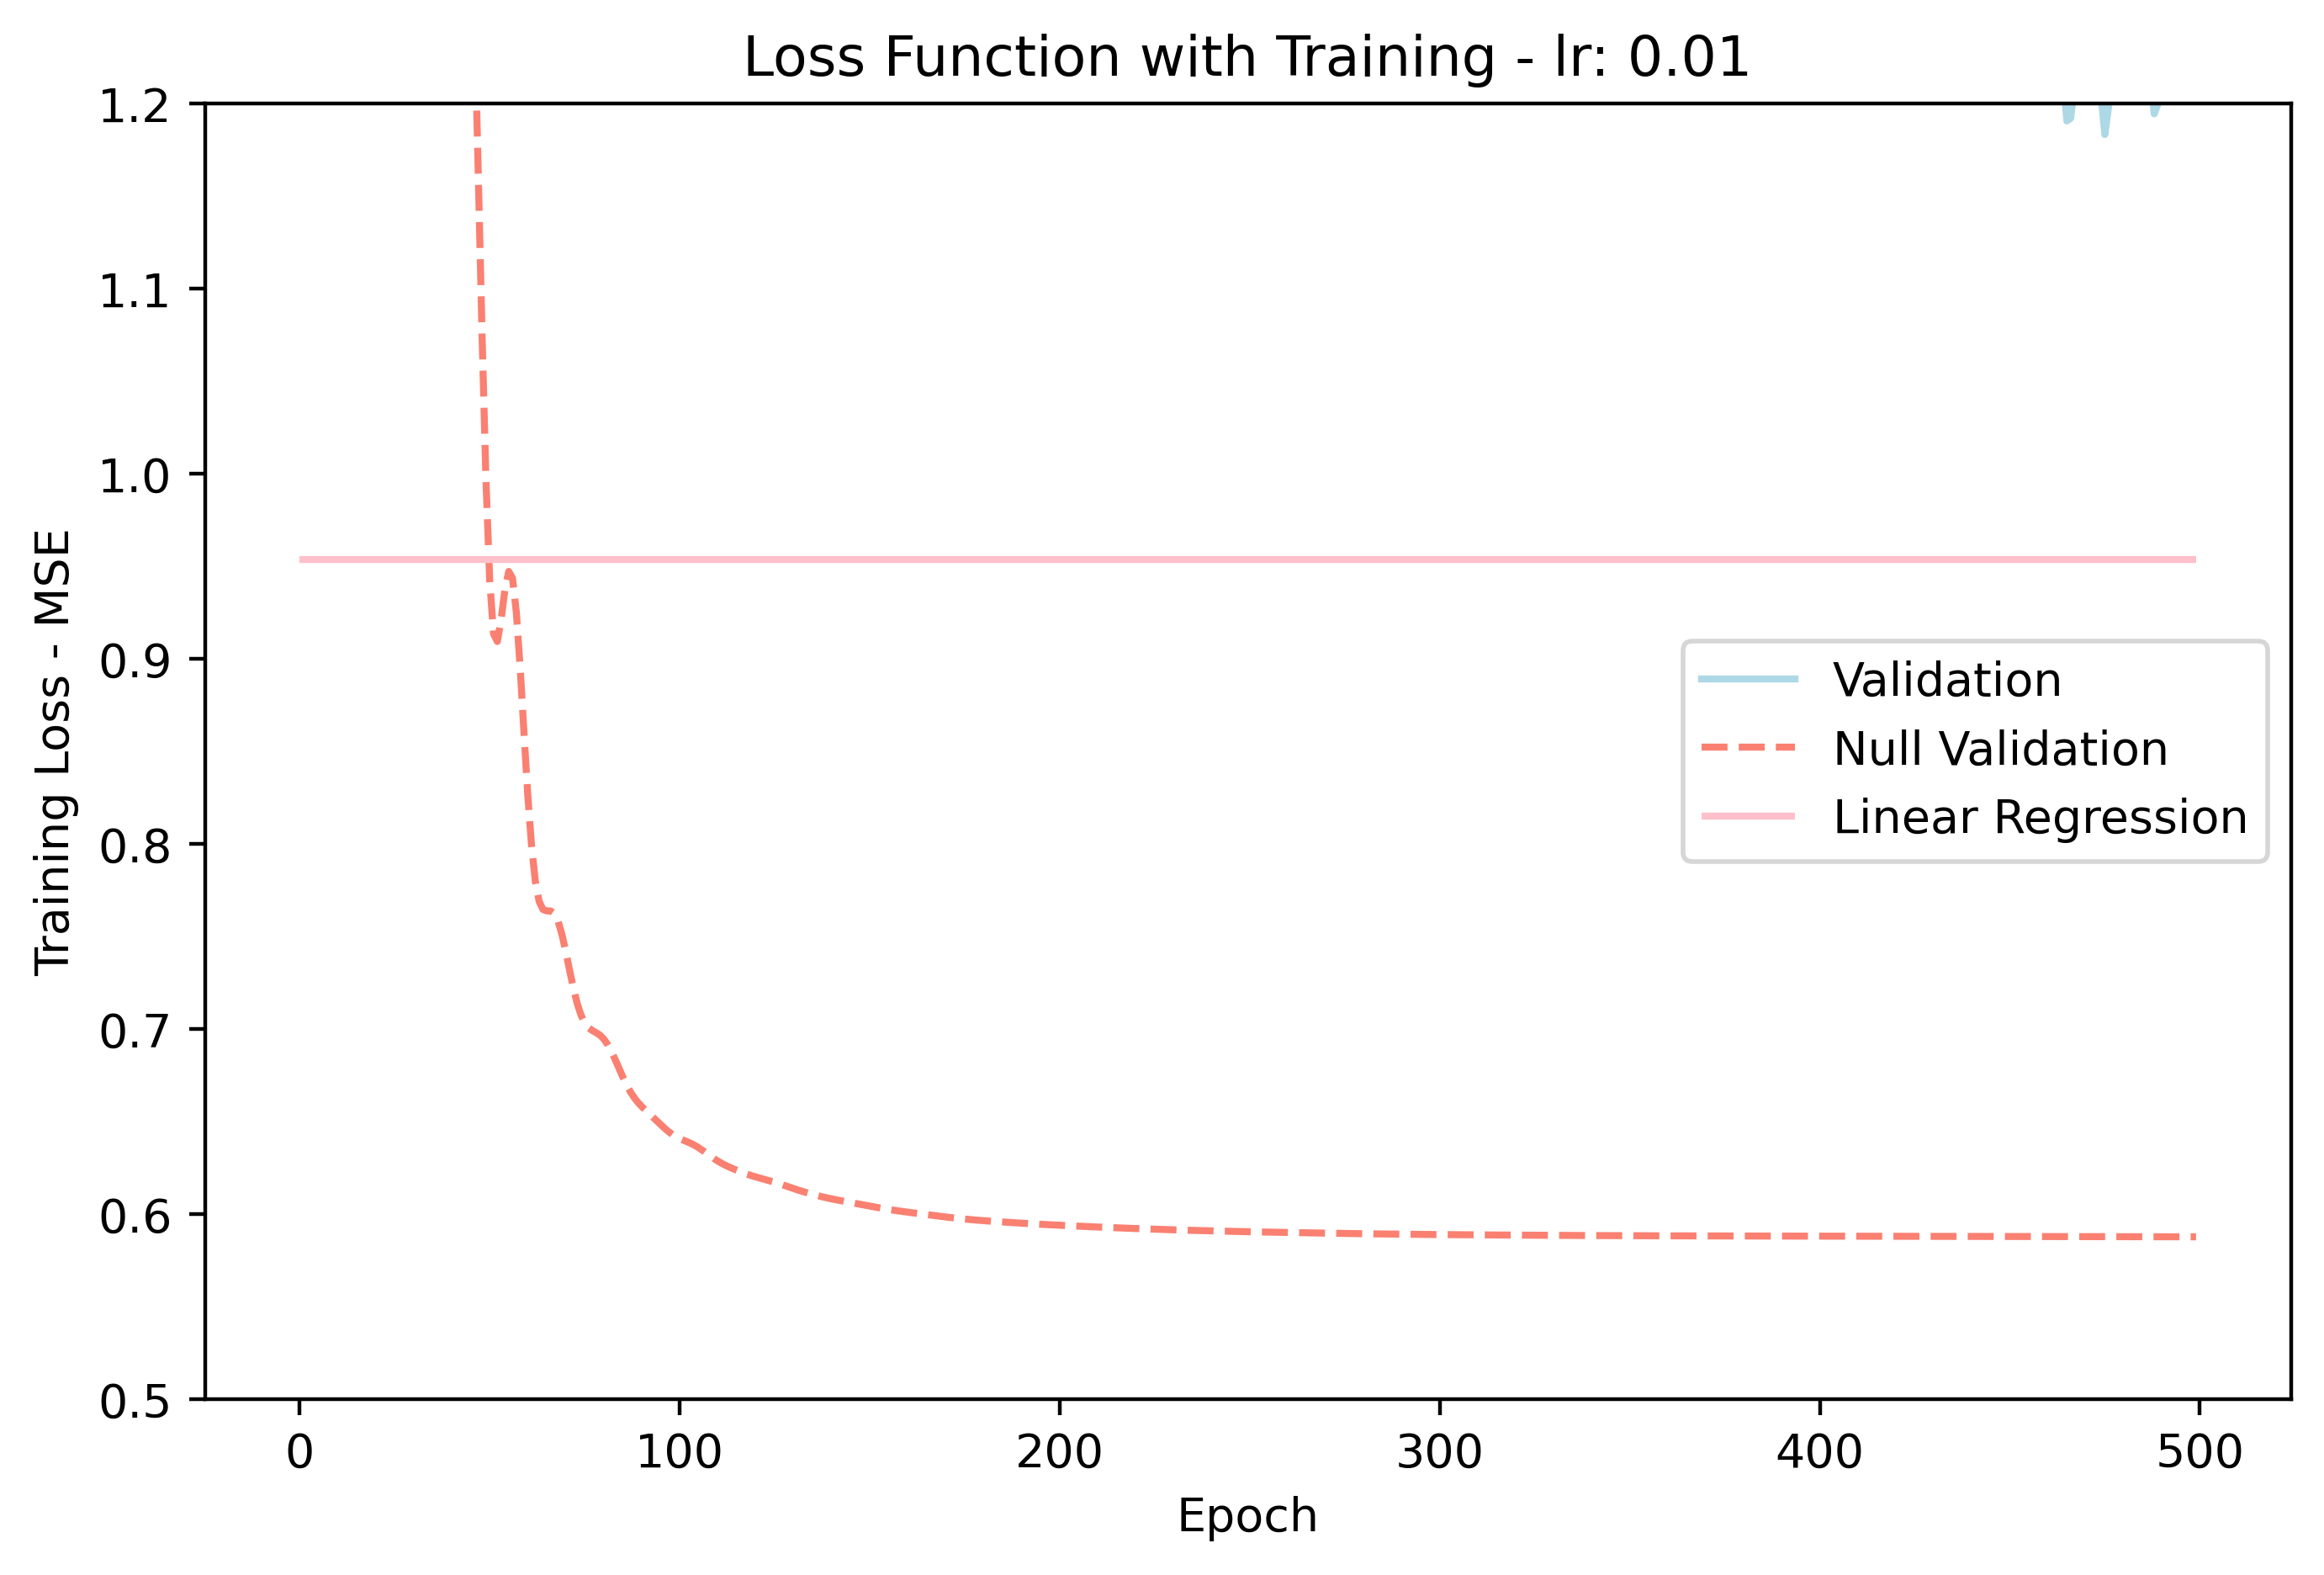

In [137]:
fig, ax = plt.subplots(figsize=(8,5), dpi=400)
fig.patch.set_facecolor('white')

ax.set_facecolor('white')
# plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

# plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')

plt.hlines(valmean[0], min(domain), max(domain), color='pink', label="Linear Regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

# plt.yscale("log")
plt.ylim((0.5,1.2))

plt.savefig(os.path.join(results_dir, 'model_comparison.png'), bbox_inches="tight", transparent=True)
plt.show()

In [138]:
z6 = np.polyfit(distances, m6l,2)
p6 = np.poly1d(z6)

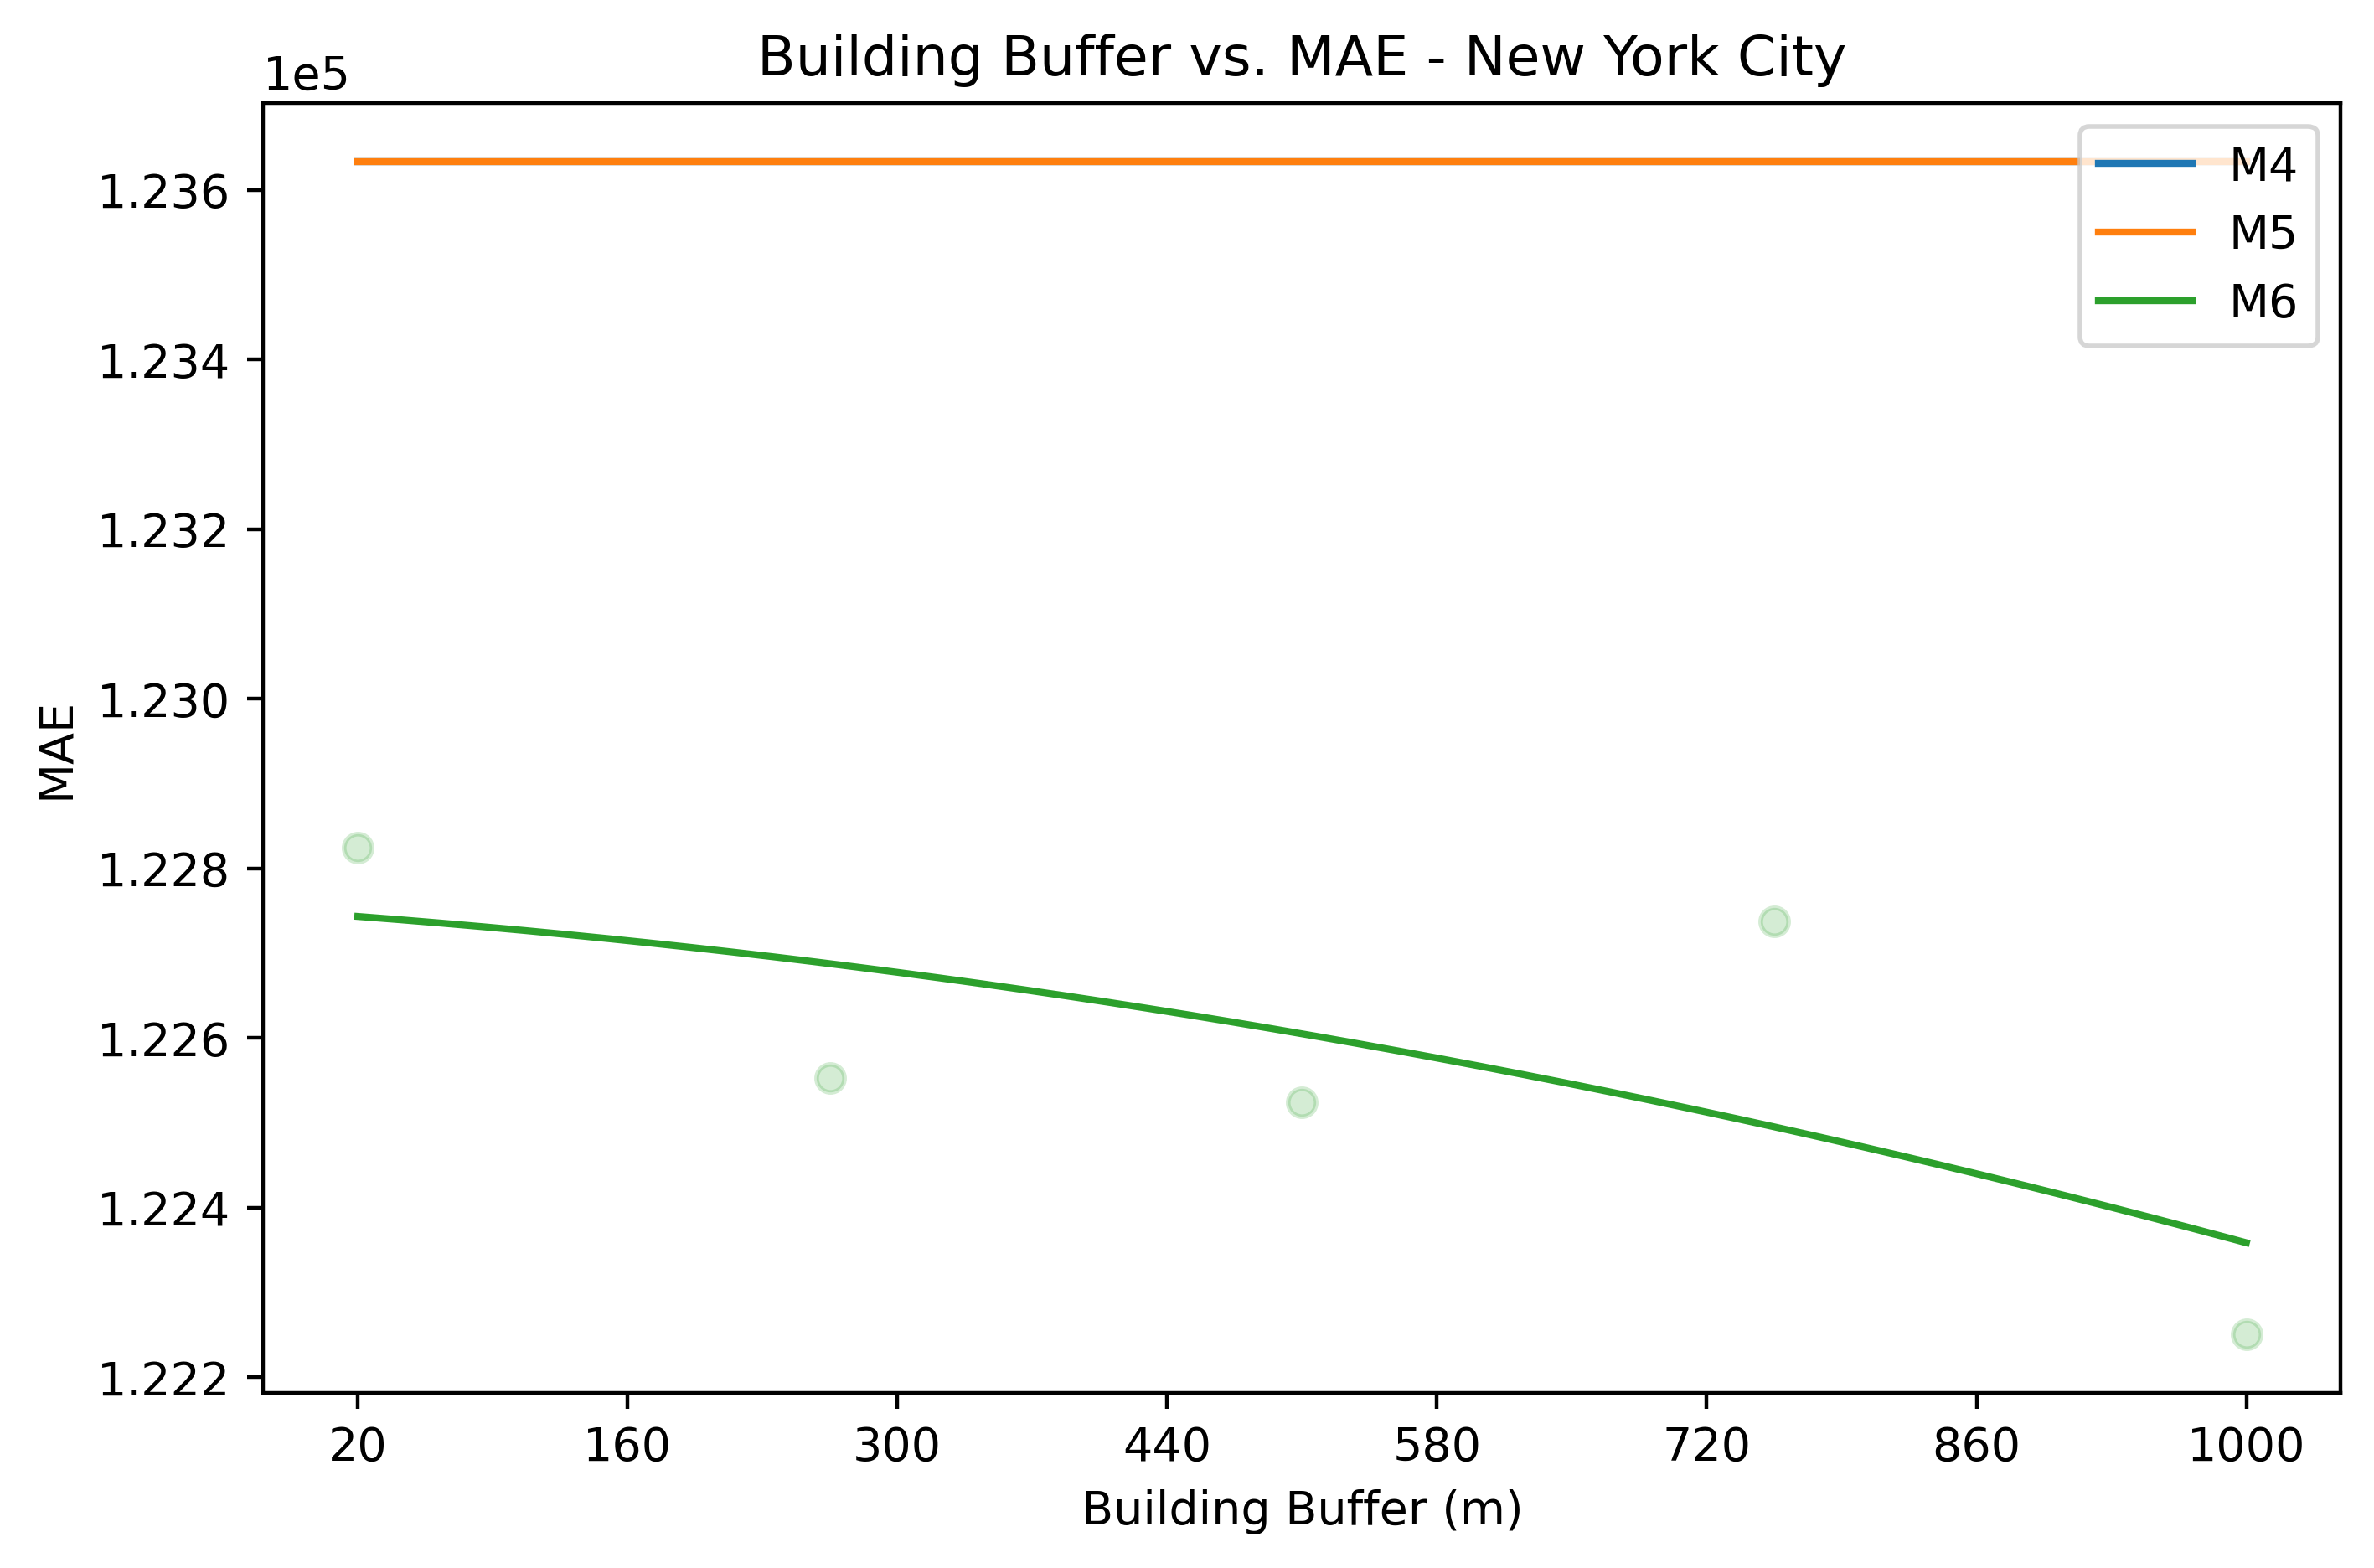

In [139]:
# plt.scatter(training_corpus

s = 0.0005
# m1s = splrep(distances, np.array(m1l), s=s)
# m2s = splrep(distances, np.array(m2l), s=s)
# m3s = splrep(distances, np.array(m3l), s=s)
# m4s = splrep(distances, np.array(m4l), s=s)
# m5s = splrep(distances, np.array(m5l), s=s)
# m6s = splrep(distances, np.array(m6l), s=s)

fig, ax = plt.subplots(figsize=(8,5), dpi=400)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# plt.yscale("log")

alpha = 0.2

# plt.scatter(distances, m1a, alpha=0)
# plt.scatter(distances, m2a, alpha=0)
# plt.scatter(distances, m3a, alpha=alpha)
plt.scatter(distances, m4l, alpha=0)
plt.scatter(distances, m5l, alpha=0)
plt.scatter(distances, m6l, alpha=alpha)

newdist = np.linspace(distances[0], distances[-1], 500)
# plt.plot(newdist, csaps(distances, m1a, newdist, smooth=s), label="M1")
# plt.plot(newdist, csaps(distances, m2a, newdist, smooth=s), label="M2")
# plt.plot(newdist, csaps(distances, m3a, newdist, smooth=s), label="M3")
plt.plot(newdist, csaps(distances, m4l, newdist, smooth=s), label="M4")
plt.plot(newdist, csaps(distances, m5l, newdist, smooth=s), label="M5")
plt.plot(newdist, p6(newdist), label="M6")

plt.ylabel("MAE")
plt.xlabel("Building Buffer (m)")

plt.title("Building Buffer vs. MAE - New York City")
plt.ticklabel_format(axis='y', style='sci', scilimits=(2,4))
plt.xticks(np.linspace(distances.min(), distances.max(), 8))

plt.legend(loc="upper right")
plt.savefig(os.path.join(results_dir, "contextual_significance_mae.png"))
plt.show()

In [140]:
nycfootprints = g1a['footprints']
nycfootprints['logenergy'] = np.log(nycfootprints.energy)

# nycfootprints.explore('logenergy')

In [141]:
torch.exp(null_predictions)

tensor([1750.4171, 1582.3997, 2986.8345, 5416.3657, 2425.4937, 4030.9597,
        4782.0737, 8569.5801, 9587.4482, 3076.1558, 3643.3882, 4352.9985,
        5514.5205, 5300.2695, 1397.6360, 4356.3667, 6199.1309, 5950.9214,
        5098.1572, 6261.7690, 7451.4819, 2421.4260], device='cuda:0')

In [142]:
testidx = (~g2a['training_mask']).detach().cpu().numpy()
testidx

array([False,  True,  True, ..., False, False, False])

In [143]:
rebuilding_idx = np.array(g2a['rebuild_idx'])

In [144]:
g1a['footprints']

,id,geometry,energy,area,year,hdd,cdd,logenergy
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485,6.929539
1,10426804091157841868,"POLYGON ((585927.840 4510967.054, 585913.878 4...",7476.661849,43841.823131,2012,1620.297029,5374.593192,8.919542
2,13984590206613124140,"POLYGON ((587451.332 4512457.088, 587424.453 4...",375055.715748,7460.121331,2012,2666.601277,4496.516306,12.834830
3,18069133829578216584,"POLYGON ((587479.460 4512496.111, 587446.628 4...",1054.787223,9754.828640,2012,2708.235108,4526.787425,6.961094
4,3936784749187828781,"POLYGON ((587445.747 4512512.119, 587423.893 4...",1551.129944,8602.179507,2012,2704.813270,4501.906827,7.346739
...,...,...,...,...,...,...,...,...
12793,12618438599830320340,"POLYGON ((592296.077 4509139.097, 592238.791 4...",1382.376267,8915.263055,2012,1850.400488,6666.884704,7.231559
12794,5493187043257100533,"POLYGON ((588931.564 4517977.890, 588891.523 4...",6265.973495,25350.105445,2012,3033.461015,5083.970271,8.742889
12795,15242956676492688919,"POLYGON ((587808.975 4516068.062, 587741.570 4...",784.407552,1207.740689,2016,3393.641800,3264.480132,6.664929
12796,7395414680666969706,"POLYGON ((583950.549 4509920.789, 583949.374 4...",298.200742,3496.688003,2017,2569.869132,5047.240305,5.697767


In [145]:
config

{'random_seed': 10,
 'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.15,
 'test_percent': 15,
 'building_buffer': 400,
 'building_buffer_min': 20,
 'building_buffer_max': 1000,
 'building_buffer_npoints': 5,
 'neighbor_radius': 100,
 'n_cv': 3,
 'n_cv_generalization': 2,
 'cv_size': 1179,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area'],
 'input_shape': 3}

In [146]:
# g1, g1a = graph("new-york", **config)
# g1a['footprints']['logenergy'] = np.log(g1a['footprints'].energy)


# g1p = pool_adjacency(g1, g1a)

# ## building these using generalization parameters from New York
# g2, g2a = graph("san-francisco", **{**config, **{"normalization": g1a["normalization"]}})
# g2a['footprints']['logenergy'] = np.log(g2a['footprints'].energy)
# g2p = pool_adjacency(g2, g2a)

# g3, g3a = graph("austin", **{**config, **{"normalization": g1a["normalization"]}})
# g3a['footprints']['logenergy'] = np.log(g3a['footprints'].energy)
# g3p = pool_adjacency(g3, g3a)

In [147]:
# ## building these using generalization parameters from New York
# g2, g2a = graph("san-francisco", **{**config, **{"normalization": g1a["normalization"]}})
# g2a['footprints']['logenergy'] = np.log(g2a['footprints'].energy)
# g2p = pool_adjacency(g2, g2a)

# g3, g3a = graph("austin", **{**config, **{"normalization": g1a["normalization"]}})
# g3a['footprints']['logenergy'] = np.log(g3a['footprints'].energy)
# g3p = pool_adjacency(g3, g3a)

In [148]:
g1a.keys()

dict_keys(['rebuild_idx', 'node_data', 'node_data_original', 'footprints', 'training_mask', 'test_mask', 'normalization'])

In [149]:
g1a['footprints'].logenergy

0         6.929539
1         8.919542
2        12.834830
3         6.961094
4         7.346739
           ...    
12793     7.231559
12794     8.742889
12795     6.664929
12796     5.697767
12797     7.490133
Name: logenergy, Length: 12798, dtype: float64

In [150]:
g1a['footprints']

,id,geometry,energy,area,year,hdd,cdd,logenergy
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485,6.929539
1,10426804091157841868,"POLYGON ((585927.840 4510967.054, 585913.878 4...",7476.661849,43841.823131,2012,1620.297029,5374.593192,8.919542
2,13984590206613124140,"POLYGON ((587451.332 4512457.088, 587424.453 4...",375055.715748,7460.121331,2012,2666.601277,4496.516306,12.834830
3,18069133829578216584,"POLYGON ((587479.460 4512496.111, 587446.628 4...",1054.787223,9754.828640,2012,2708.235108,4526.787425,6.961094
4,3936784749187828781,"POLYGON ((587445.747 4512512.119, 587423.893 4...",1551.129944,8602.179507,2012,2704.813270,4501.906827,7.346739
...,...,...,...,...,...,...,...,...
12793,12618438599830320340,"POLYGON ((592296.077 4509139.097, 592238.791 4...",1382.376267,8915.263055,2012,1850.400488,6666.884704,7.231559
12794,5493187043257100533,"POLYGON ((588931.564 4517977.890, 588891.523 4...",6265.973495,25350.105445,2012,3033.461015,5083.970271,8.742889
12795,15242956676492688919,"POLYGON ((587808.975 4516068.062, 587741.570 4...",784.407552,1207.740689,2016,3393.641800,3264.480132,6.664929
12796,7395414680666969706,"POLYGON ((583950.549 4509920.789, 583949.374 4...",298.200742,3496.688003,2017,2569.869132,5047.240305,5.697767


In [151]:
config

{'random_seed': 10,
 'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.15,
 'test_percent': 15,
 'building_buffer': 400,
 'building_buffer_min': 20,
 'building_buffer_max': 1000,
 'building_buffer_npoints': 5,
 'neighbor_radius': 100,
 'n_cv': 3,
 'n_cv_generalization': 2,
 'cv_size': 1179,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area'],
 'input_shape': 3}

In [152]:
# # now examining how this may generalize
# model.eval()
# nullmodel.eval()

# with torch.no_grad():
#     print("San Francisco")
#     testidx = (~g2a['training_mask']).detach().cpu().numpy()
#     rebuilding_idx = np.array(g2a['rebuild_idx'])
#     null_predictions = nullmodel(g2['footprint'].x).squeeze()[testidx]
    
#     linear_predictions = reg.predict(g2['footprint'].x.cpu().numpy())[testidx]
#     estimates = model(g2.x_dict, g2.edge_index_dict).squeeze().detach()[testidx]
#     recorded = g2['footprint'].y[testidx]

#     linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
#     null_loss = loss_func(null_predictions, recorded)
#     graph_loss = loss_func(estimates, recorded)
#     print("Linear Loss:\t{:0.2f}".format(linear_loss))
#     print("Null Loss:\t{:0.2f}".format(null_loss))
#     print("Graph Loss:\t{:0.2f}".format(graph_loss))
#     print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [153]:
# f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
# f.write(str("San Francisco Test Set Results - No Finetuning:\n"))

# f.write(("Linear Loss:\t{:0.3f}\n".format(linear_loss)))
# f.write(("Null Loss:\t\t{:0.3f}\n".format(null_loss)))
# f.write(("Graph Loss:\t\t{:0.3f}\n".format(graph_loss)))
# f.write(("Percent Ben:\t{:0.3f}\n\n".format(100 * (graph_loss - null_loss)/null_loss)))

# f.close()

In [154]:
# nullmodel.eval()
# model.eval()
# with torch.no_grad():
#     print("Austin Texas")
#     testidx = (~g3a['training_mask']).detach().cpu().numpy()
#     rebuilding_idx = np.array(g3a['rebuild_idx'])
#     null_predictions = nullmodel(g3['footprint'].x).squeeze()[testidx]
    
#     linear_predictions = reg.predict(g3['footprint'].x.cpu().numpy())[testidx]
    
#     estimates = model(g3.x_dict, g3.edge_index_dict).squeeze().detach()[testidx]
#     recorded = g3['footprint'].y[testidx]
    
#     linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
#     null_loss = loss_func(null_predictions, recorded)
#     graph_loss = loss_func(estimates, recorded)
#     print("Linear Loss:\t{:0.2f}".format(linear_loss))
#     print("Null Loss:\t{:0.2f}".format(null_loss))
#     print("Graph Loss:\t{:0.2f}".format(graph_loss))
#     print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [155]:
# f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
# f.write(str("Austin Test Set Results - No Finetuning:\n"))

# f.write(("Linear Loss:\t{:0.3f}\n".format(linear_loss)))
# f.write(("Null Loss:\t\t{:0.3f}\n".format(null_loss)))
# f.write(("Graph Loss:\t\t{:0.3f}\n".format(graph_loss)))
# f.write(("Percent Ben:\t{:0.3f}\n\n".format(100 * (graph_loss - null_loss)/null_loss)))

# f.close()

In [156]:
optim = config['custom_optimizer']
optim(model.parameters())

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [157]:
### I used the below cells to evaluate how many epochs to use for the final model

In [158]:


# model.load_state_dict(default_modelstate)
# model.train()

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     model.to(device),
#     lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config
# )

# nystate_dict = copy.deepcopy(nystate_dict_origin)

In [159]:
# from src.trainer import trainer
# from src.cv import reset_model

# nullmodel.load_state_dict(default_nullmodelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     nullmodel.to(device),
#     lambda: nullmodel(nycgraph['footprint'].x),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config
# )

# nynull_state_dict = copy.deepcopy(nystate_dict_origin)

In [160]:
# plt.plot(trainlosses, label="training")
# plt.plot(testlosses, label="testing")

# plt.legend()
# plt.yscale("log")

# plt.show()

In [161]:
# # this is manually set based on the above graph^
# from src.trainer import trainer

# model.load_state_dict(default_modelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# trainmask = np.repeat([True], len(trainmask))
# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     model.to(device),
#     lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config,
#     fulldata = True
# )

# nystate_dict = copy.deepcopy(nystate_dict_origin)

In [162]:
# nullmodel.train()
# nullmodel.load_state_dict(default_nullmodelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# trainmask = np.repeat([True], len(trainmask))
# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     nullmodel.to(device),
#     lambda: nullmodel(nycgraph['footprint'].x),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config,
#     fulldata = True
# )

# nystate_nulldict = copy.deepcopy(nystate_dict_origin)

In [163]:
# np.vstack((nyX, sfgraph['footprint'].x[:50].cpu().detach())).shape

In [164]:
### this is going to be the drip system, to understand how slow incorporation of data changes the prediction quality

In [165]:
# nyY

In [166]:
# 150 * 30 * 52 * 40 / 1e6

In [167]:
# from tqdm import tqdm_notebook

# # now exploring how the model might generalize to SF
# sf_linearvalloss = []

# sf_valloss = []
# sf_nullvalloss = []

# config['epochs'] = 300

# for n_true in tqdm_notebook(range(100), leave=True):
#     model.load_state_dict(nystate_dict)
#     nullmodel.load_state_dict(nullnystate_dict)
    
#     model.train()
#     nullmodel.train()

#     sf_trainmask = copy.deepcopy(g2a['training_mask'])
#     sf_testmask = copy.deepcopy((~g2a['training_mask']))

#     sf_to_false = np.where(sf_trainmask.cpu().numpy())[0]
#     sf_to_false

#     np.random.seed(1)
#     drip_idx = np.random.choice(sf_to_false, n_true, replace=False)

#     # this now just drips in a bit of the sf data
#     sf_trainmask = np.repeat([False], len(sf_trainmask))
#     sf_trainmask[drip_idx] = True

#     rebuild_idx = np.array(g2a['rebuild_idx'])
    
#     # shapes
#     # print(f"trainmask shape: {trainmask.shape}")
    
#     ## building the linear model
#     x_linear_addition = np.vstack((nyX, g2['footprint'].x[sf_trainmask].cpu().detach()))
    
#     # print(f"Y shape: {nyY.shape}.")
#     # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
#     y_linear_addition = np.concatenate((nyY, g2['footprint'].y[sf_trainmask].cpu().detach()), axis=None)
    
#     reg = LinearRegression().fit(x_linear_addition, y_linear_addition)
#     preds = reg.predict(g2['footprint'].x[sf_testmask].cpu().detach())
#     existing_terms = g2['footprint'].y[sf_testmask].cpu().detach()
#     # print(f"Predictions: {preds}")
#     # print(f"Existing: {existing_terms}")
#     sf_linearvalloss.append(loss_func(torch.tensor(preds), existing_terms))

#     sf_state_dict, sf_trainlosses, sf_testlosses = trainer(
#         model.to(device),
#         lambda: model(g2.x_dict, g2.edge_index_dict),
#         rebuild_idx,
#         sf_trainmask,
#         sf_testmask,
#         recorded = g2['footprint'].y,
#         loss_func = loss_func,
#         config = config
#     )
    
#     _, _, sf_nulltestlosses = trainer(
#         nullmodel.to(device),
#         lambda: nullmodel(g2['footprint'].x),
#         rebuild_idx,
#         sf_trainmask,
#         sf_testmask,
#         recorded = g2['footprint'].y,
#         loss_func = loss_func,
#         config = config
#     )
#     sf_valloss.append(sf_testlosses)
#     sf_nullvalloss.append(sf_nulltestlosses)

In [168]:
generalization_cv = 8
# config['epochs'] = 300

In [169]:
config['n_cv']

3

In [170]:
g2['footprint'].y

tensor([8.7069, 8.6743, 7.3443,  ..., 6.2166, 8.2077, 6.6190], device='cuda:0')

In [171]:
config

{'random_seed': 10,
 'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.15,
 'test_percent': 15,
 'building_buffer': 400,
 'building_buffer_min': 20,
 'building_buffer_max': 1000,
 'building_buffer_npoints': 5,
 'neighbor_radius': 100,
 'n_cv': 3,
 'n_cv_generalization': 2,
 'cv_size': 1179,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area'],
 'input_shape': 3}

In [172]:
list(range(0,100,5))

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [173]:
# now exploring how the model might generalize to SF
sf_linearvalloss = []
sf_valloss = []
sf_nullvalloss = []

for n_true in tqdm_notebook(generalization_range, leave=True):
    modelcv_loss = []
    nullmodelcv_loss = []
    linearcv_loss = []
    
    for cv in range(config['n_cv_generalization']):
        model.load_state_dict(nystate_dict)
        nullmodel.load_state_dict(nullnystate_dict)
        seed_everything(rand)
        
        model.train()
        nullmodel.train()

        sf_trainmask = copy.deepcopy(g2a['training_mask'].cpu().numpy())
        
        # in order for the crossvalidation to work, the seeds should be a bit different on each iteration
        np.random.seed(cv)
        np.random.shuffle(sf_trainmask)

        sf_testmask = ~sf_trainmask
        sf_to_false = np.where(sf_trainmask)[0]
        sf_to_false

        np.random.seed(cv)
        drip_idx = np.random.choice(sf_to_false, n_true, replace=False)

        # this now just drips in a bit of the sf data
        sf_trainmask = np.repeat([False], len(sf_trainmask))
        sf_trainmask[drip_idx] = True

        rebuild_idx = np.array(g2a['rebuild_idx'])

        # shapes
        # print(f"trainmask shape: {trainmask.shape}")

        ## building the linear model
        x_linear_addition = np.vstack((nyX, g2['footprint'].x[sf_trainmask].cpu().detach()))

        # print(f"Y shape: {nyY.shape}.")
        # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
        y_linear_addition = np.concatenate((nyY, g2['footprint'].y[sf_trainmask].cpu().detach()), axis=None)

        linearmodel = ElasticNet()
        reg = linearmodel.fit(x_linear_addition, y_linear_addition)
        preds = reg.predict(g2['footprint'].x[sf_testmask].cpu().detach())
        existing_terms = g2['footprint'].y[sf_testmask].cpu().detach()
        # print(f"Predictions: {preds}")
        # print(f"Existing: {existing_terms}")
        linearcv_loss.append(loss_func(torch.tensor(preds), existing_terms))

        sf_state_dict, sf_trainlosses, sf_testlosses = trainer(
            model.to(device),
            lambda: model(g2.x_dict, g2.edge_index_dict),
            rebuild_idx,
            sf_trainmask,
            sf_testmask,
            recorded = g2['footprint'].y,
            loss_func = loss_func,
            config = config
        )

        _, _, sf_nulltestlosses = trainer(
            nullmodel.to(device),
            lambda: nullmodel(g2['footprint'].x),
            rebuild_idx,
            sf_trainmask,
            sf_testmask,
            recorded = g2['footprint'].y,
            loss_func = loss_func,
            config = config
        )
        modelcv_loss.append(sf_testlosses)
        nullmodelcv_loss.append(sf_nulltestlosses)
        
    sf_linearvalloss.append(linearcv_loss)
    sf_valloss.append(modelcv_loss)
    sf_nullvalloss.append(nullmodelcv_loss)
        
sf_linearvalloss = np.array(sf_linearvalloss)
sf_valloss = np.array(sf_valloss)
sf_nullvalloss = np.array(sf_nullvalloss)

/tmp/ipykernel_41183/350916348.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_true in tqdm_notebook(generalization_range, leave=True):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

In [174]:
np.percentile(sf_linearvalloss, 5, axis=1)

array([2.66426908, 2.65883741, 2.65238329, 2.64510229, 2.63929647])

In [175]:
np.arange(50)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [176]:
sf_linearvalloss.mean(axis=1)[-1]

2.9229279

In [177]:
sf_nullvalloss.min(axis=2).mean(axis=1)[-1]

0.7422015368938446

In [178]:
sf_valloss.min(axis=2).mean(axis=1)[-1]

0.6948576867580414

In [179]:
1 - sf_valloss.min(axis=2).mean(axis=1)[-1] / sf_linearvalloss.mean(axis=1)[-1]

0.7622734049949884

In [180]:
1 - sf_valloss.min(axis=2).mean(axis=1)[-1] / sf_nullvalloss.min(axis=2).mean(axis=1)[-1]

0.06378840218243131

In [181]:
sf_nullvalloss.min(axis=2).shape

(5, 2)

In [182]:
# np.percentile(sf_nullvalloss

In [183]:
np.median(sf_linearvalloss, axis=1)

array([2.9507408, 2.9440022, 2.9384437, 2.9307706, 2.9229279],
      dtype=float32)

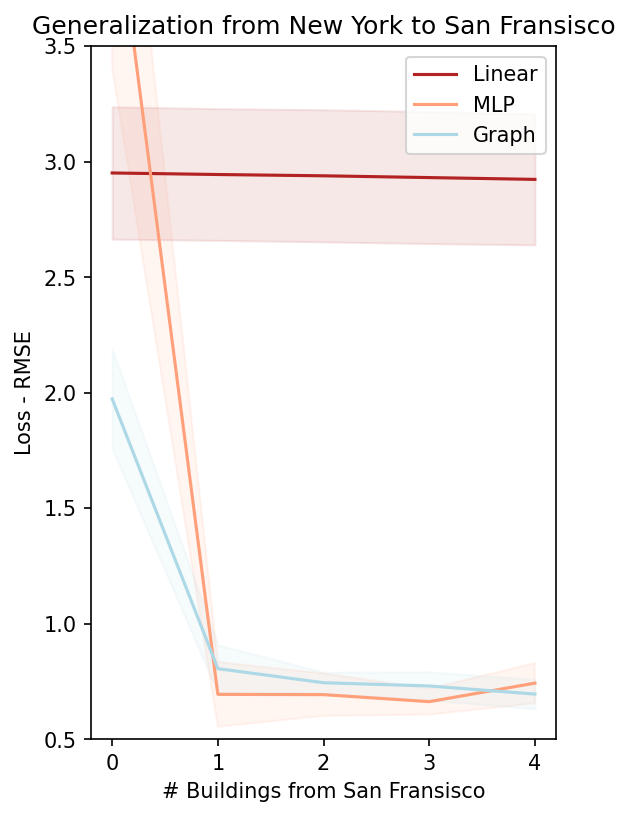

In [184]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(4, 6), dpi=150)

# plt.plot(sf_linearvalloss, label="Linear", color="coral")
# plt.plot(np.percentile(sf_nullvalloss, 5, axis=1), label="MLP", color="orange")
# plt.plot(np.percentile(sf_valloss, 2, axis=1), label="Graph", color="lightblue")
lower = 5
upper = 95

plt.plot(np.median(sf_linearvalloss, axis=1), label="Linear", color="firebrick")
plt.fill_between(
    np.arange(sf_linearvalloss.shape[0]), 
    np.percentile(sf_linearvalloss, lower, axis=1), 
    np.percentile(sf_linearvalloss, upper, axis=1), 
    color="firebrick", 
    alpha=0.1
)

plt.plot(np.median(sf_nullvalloss.min(axis=2), axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(sf_nullvalloss.shape[0]), 
    np.percentile(sf_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(sf_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(np.median(sf_valloss.min(axis=2), axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(sf_valloss.shape[0]), 
    np.percentile(sf_valloss.min(axis=2), lower, axis=1), 
    np.percentile(sf_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend(loc='upper right')
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to San Fransisco")
plt.xlabel("# Buildings from San Fransisco")
plt.ylabel("Loss - RMSE")

plt.ylim((0.5,3.5))

plt.savefig(os.path.join(results_dir, 'sf_generalization.png'), bbox_inches="tight")
plt.show()

In [185]:
g3train = copy.deepcopy((g3a['training_mask']).cpu().numpy())
np.random.shuffle(g3train)

g3test = ~g3train

In [186]:
config

{'random_seed': 10,
 'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.15,
 'test_percent': 15,
 'building_buffer': 400,
 'building_buffer_min': 20,
 'building_buffer_max': 1000,
 'building_buffer_npoints': 5,
 'neighbor_radius': 100,
 'n_cv': 3,
 'n_cv_generalization': 2,
 'cv_size': 1179,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area'],
 'input_shape': 3}

In [187]:
g3['footprint']

{'x': tensor([[-3.9127, -4.9475,  8.1083],
        [-2.2812, -4.9475, 11.1724],
        [-3.4036, -4.9475,  9.2956],
        [-4.0793, -4.9475,  8.6780],
        [-3.3040, -4.9475, 10.8160],
        [-1.7257, -4.9475,  7.7646],
        [-3.0708, -4.9475,  9.5942],
        [-2.8345, -4.9475,  6.3062],
        [-0.3139, -4.9475, 10.4275],
        [-3.6348, -4.9475,  9.1843],
        [-4.3720, -4.9475, 10.1211],
        [-3.4260, -4.9475,  9.1118],
        [-3.0708, -4.9475, 11.0873],
        [-3.2728, -4.9475, 10.5428],
        [-1.3123, -4.9475,  9.7115],
        [-4.2691, -4.9475,  9.0912],
        [-2.9759, -4.9475,  6.0207],
        [-4.2691, -4.9475, 12.1397],
        [-3.7267, -4.9475, 10.2816],
        [-3.7515, -4.9475,  7.5006],
        [-1.7370, -4.9475,  8.0846],
        [-2.7037, -4.9475,  8.2900],
        [-2.4228, -4.9475,  8.1849],
        [-3.5493, -4.9475, 11.7258],
        [-2.8393, -4.9475, 10.4830],
        [-2.5397, -4.9475,  9.7641],
        [-1.3613, -4.9475, 11.56

In [188]:
# now exploring how the model might generalize to Austin
austin_linearvalloss = []
austin_valloss = []
austin_nullvalloss = []

for n_true in tqdm_notebook(generalization_range, leave=True):
    modelcv_loss = []
    nullmodelcv_loss = []
    linearcv_loss = []
    
    for cv in range(config['n_cv_generalization']):
        model.load_state_dict(nystate_dict)
        nullmodel.load_state_dict(nullnystate_dict)
        seed_everything(rand)
        
        model.train()
        nullmodel.train()
        
        austin_trainmask = copy.deepcopy(g3a['training_mask'].cpu().numpy())
        
        np.random.seed(cv)
        np.random.shuffle(austin_trainmask)

        austin_testmask = ~austin_trainmask
        austin_to_false = np.where(austin_trainmask)[0]
        austin_to_false

        np.random.seed(cv)
        drip_idx = np.random.choice(austin_to_false, n_true, replace=False)

        # this now just drips in a bit of the sf data
        austin_trainmask = np.repeat([False], len(austin_trainmask))
        austin_trainmask[drip_idx] = True

        rebuild_idx = np.array(g3a['rebuild_idx'])

        # shapes
        # print(f"trainmask shape: {trainmask.shape}")

        ## building the linear model
        x_linear_addition = np.vstack((nyX, g3['footprint'].x[austin_trainmask].cpu().detach()))

        # print(f"Y shape: {nyY.shape}.")
        # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
        y_linear_addition = np.concatenate((nyY, g3['footprint'].y[austin_trainmask].cpu().detach()), axis=None)

        linearmodel = ElasticNet()
        reg = linearmodel.fit(x_linear_addition, y_linear_addition)
        preds = reg.predict(g3['footprint'].x[austin_testmask].cpu().detach())
        existing_terms = g3['footprint'].y[austin_testmask].cpu().detach()
        # print(f"Predictions: {preds}")
        # print(f"Existing: {existing_terms}")
        linearcv_loss.append(loss_func(torch.tensor(preds), existing_terms))

        austin_state_dict, austin_trainlosses, austin_testlosses = trainer(
            model.to(device),
            lambda: model(g3.x_dict, g3.edge_index_dict),
            rebuild_idx,
            austin_trainmask,
            austin_testmask,
            recorded = g3['footprint'].y,
            loss_func = loss_func,
            config = config
        )

        _, _, austin_nulltestlosses = trainer(
            nullmodel.to(device),
            lambda: nullmodel(g3['footprint'].x),
            rebuild_idx,
            austin_trainmask,
            austin_testmask,
            recorded = g3['footprint'].y,
            loss_func = loss_func,
            config = config
        )
        modelcv_loss.append(austin_testlosses)
        nullmodelcv_loss.append(austin_nulltestlosses)
        
    austin_linearvalloss.append(linearcv_loss)
    austin_valloss.append(modelcv_loss)
    austin_nullvalloss.append(nullmodelcv_loss)
        
austin_linearvalloss = np.array(austin_linearvalloss)
austin_valloss = np.array(austin_valloss)
austin_nullvalloss = np.array(austin_nullvalloss)

/tmp/ipykernel_41183/3483111609.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_true in tqdm_notebook(generalization_range, leave=True):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

In [189]:
g3['footprint'].y

tensor([3.8185, 4.7021, 3.6602, 3.8787, 4.3026, 5.3870, 3.9550, 4.4790, 6.0586,
        4.3292, 3.6265, 3.8045, 4.1872, 3.8861, 5.3313, 3.2851, 3.9570, 3.4686,
        3.7265, 3.4507, 4.9746, 4.5342, 4.4779, 3.9146, 4.2807, 4.9069, 5.4277,
        5.6500, 5.5857, 5.3741, 5.4942, 5.4162, 4.9948, 3.2710, 4.7950, 3.9017,
        4.4207, 5.0343, 4.7573, 4.9382, 3.2490, 4.5838, 5.1711, 4.2837, 4.4503,
        4.0286, 3.9085, 4.8291, 4.7290, 5.9359, 4.3271, 3.1222, 4.8466, 4.1291,
        4.1950, 3.9717, 5.6470, 4.3633, 5.7066, 4.3015, 5.0171, 4.4355, 5.1369,
        5.3062, 5.3892, 4.6148, 2.8364, 4.2627, 4.5086, 3.9418, 6.0680, 3.9013,
        6.6921, 5.2455, 5.9991, 5.4038, 4.6150, 2.1664, 3.4536, 5.1986, 4.1270,
        4.4111, 5.1479, 3.2927, 3.4613, 5.1653, 4.4639, 4.6458, 5.0780, 4.5238,
        5.2924, 3.5901, 4.3793, 4.1606, 6.8065, 3.8150, 5.1054, 3.7589, 3.7037,
        5.1406, 4.5045, 4.6764, 4.6883, 4.4514, 3.4098, 4.4815, 5.4395, 4.4357,
        5.0263, 5.0330, 5.1464, 4.2308, 

In [190]:
austin_valloss.mean(axis=1).min(axis=0).shape

(500,)

In [191]:
austin_nullvalloss.min(axis=2).shape

(5, 2)

In [192]:
austin_linearvalloss.mean(axis=1)[-5:]

array([7.135785 , 7.0248046, 6.9115305, 6.7877693, 6.690024 ],
      dtype=float32)

In [193]:
austin_nullvalloss.min(axis=2).mean(axis=1)[-5:]

array([9.15376472, 0.15917671, 0.12003219, 0.06907077, 0.07418298])

In [194]:
austin_valloss.min(axis=2).mean(axis=1)[-5:]

array([0.88052437, 0.13550183, 0.10879825, 0.09095009, 0.08240123])

In [195]:
1 - austin_valloss.min(axis=2).mean(axis=1)[-1] / austin_linearvalloss.mean(axis=1)[-1]

0.987682969680072

In [196]:
1 - austin_valloss.min(axis=2).mean(axis=1)[-1] / austin_nullvalloss.min(axis=2).mean(axis=1)[-1]

-0.1107835194506035

In [197]:
austin_linearvalloss.mean(axis=1)[0]

7.135785

In [198]:
austin_nullvalloss.min(axis=2).mean(axis=1)[0]

9.153764724731445

In [199]:
austin_valloss.min(axis=2).mean(axis=1)[0]

0.8805243670940399

In [200]:
## this one is inital, with no generalization characteristics
sampletable = [
    {"Linear":sf_linearvalloss.mean(axis=1)[0], "MLP":sf_nullvalloss.min(axis=2).mean(axis=1)[0], "Graph": sf_valloss.min(axis=2).mean(axis=1)[0]},
    {"Linear":austin_linearvalloss.mean(axis=1)[0], "MLP":austin_nullvalloss.min(axis=2).mean(axis=1)[0], "Graph":austin_valloss.min(axis=2).mean(axis=1)[0]}
]

tabledf = pd.DataFrame(sampletable, index=["San Francisco", "Austin"]).style.format(decimal='.', thousands=',', precision=2)
print(tabledf.to_latex())

\begin{tabular}{lrrr}
 & Linear & MLP & Graph \\
San Francisco & 2.95 & 4.23 & 1.97 \\
Austin & 7.14 & 9.15 & 0.88 \\
\end{tabular}



In [201]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("Prior to Generalization:\n"))
f.write(tabledf.to_latex())
f.write("\n")
f.close()

In [202]:
# after finetuning the model a bit
sampletable = [
    {"Linear":sf_linearvalloss.mean(axis=1)[-1], "MLP":sf_nullvalloss.min(axis=2).mean(axis=1)[-1], "Graph": sf_valloss.min(axis=2).mean(axis=1)[-1]},
    {"Linear":austin_linearvalloss.mean(axis=1)[-1], "MLP":austin_nullvalloss.min(axis=2).mean(axis=1)[-1], "Graph":austin_valloss.min(axis=2).mean(axis=1)[-1]}
]

tabledf = pd.DataFrame(sampletable, index=["San Francisco", "Austin"]).style.format(decimal='.', thousands=',', precision=2)
print(tabledf.to_latex())

\begin{tabular}{lrrr}
 & Linear & MLP & Graph \\
San Francisco & 2.92 & 0.74 & 0.69 \\
Austin & 6.69 & 0.07 & 0.08 \\
\end{tabular}



In [203]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("Post Generalization - Finetuned on {} buildings:\n".format(generalization_range[-1])))
f.write(tabledf.to_latex())
f.write("\n")
f.close()

In [204]:
print(tabledf.to_latex())

\begin{tabular}{lrrr}
 & Linear & MLP & Graph \\
San Francisco & 2.92 & 0.74 & 0.69 \\
Austin & 6.69 & 0.07 & 0.08 \\
\end{tabular}



In [205]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("New York City Profile:\n"))
f.write(str("Min CV Loss:\t{:.4f}\n".format(np.min(mean_vl))))
f.write(str("5th P CV Loss:\t{:.4f}\n".format(np.percentile(mean_vl, 5))))
f.write(str("25th P CV Loss:\t{:.4f}\n\n".format(np.percentile(mean_vl, 25))))
f.close()

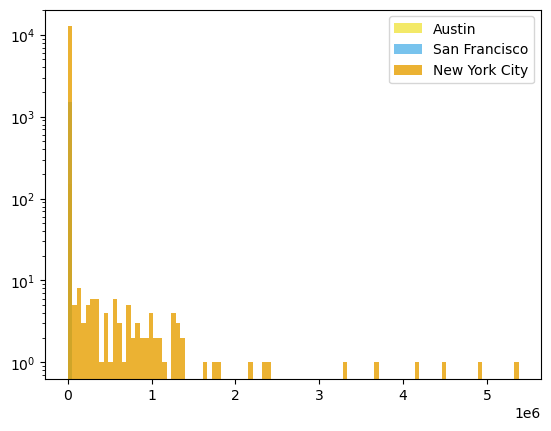

In [206]:
colors = ['#E69F00', '#56B4E9', '#F0E442']
names = ["New York City", "San Francisco", "Austin"]

plt.hist([
    g1a['footprints'].energy,
    g2a['footprints'].energy,
    g3a['footprints'].energy
], histtype='stepfilled', bins=100, alpha=0.8, label = names, color = colors)

plt.yscale("log")

plt.legend()
plt.show()

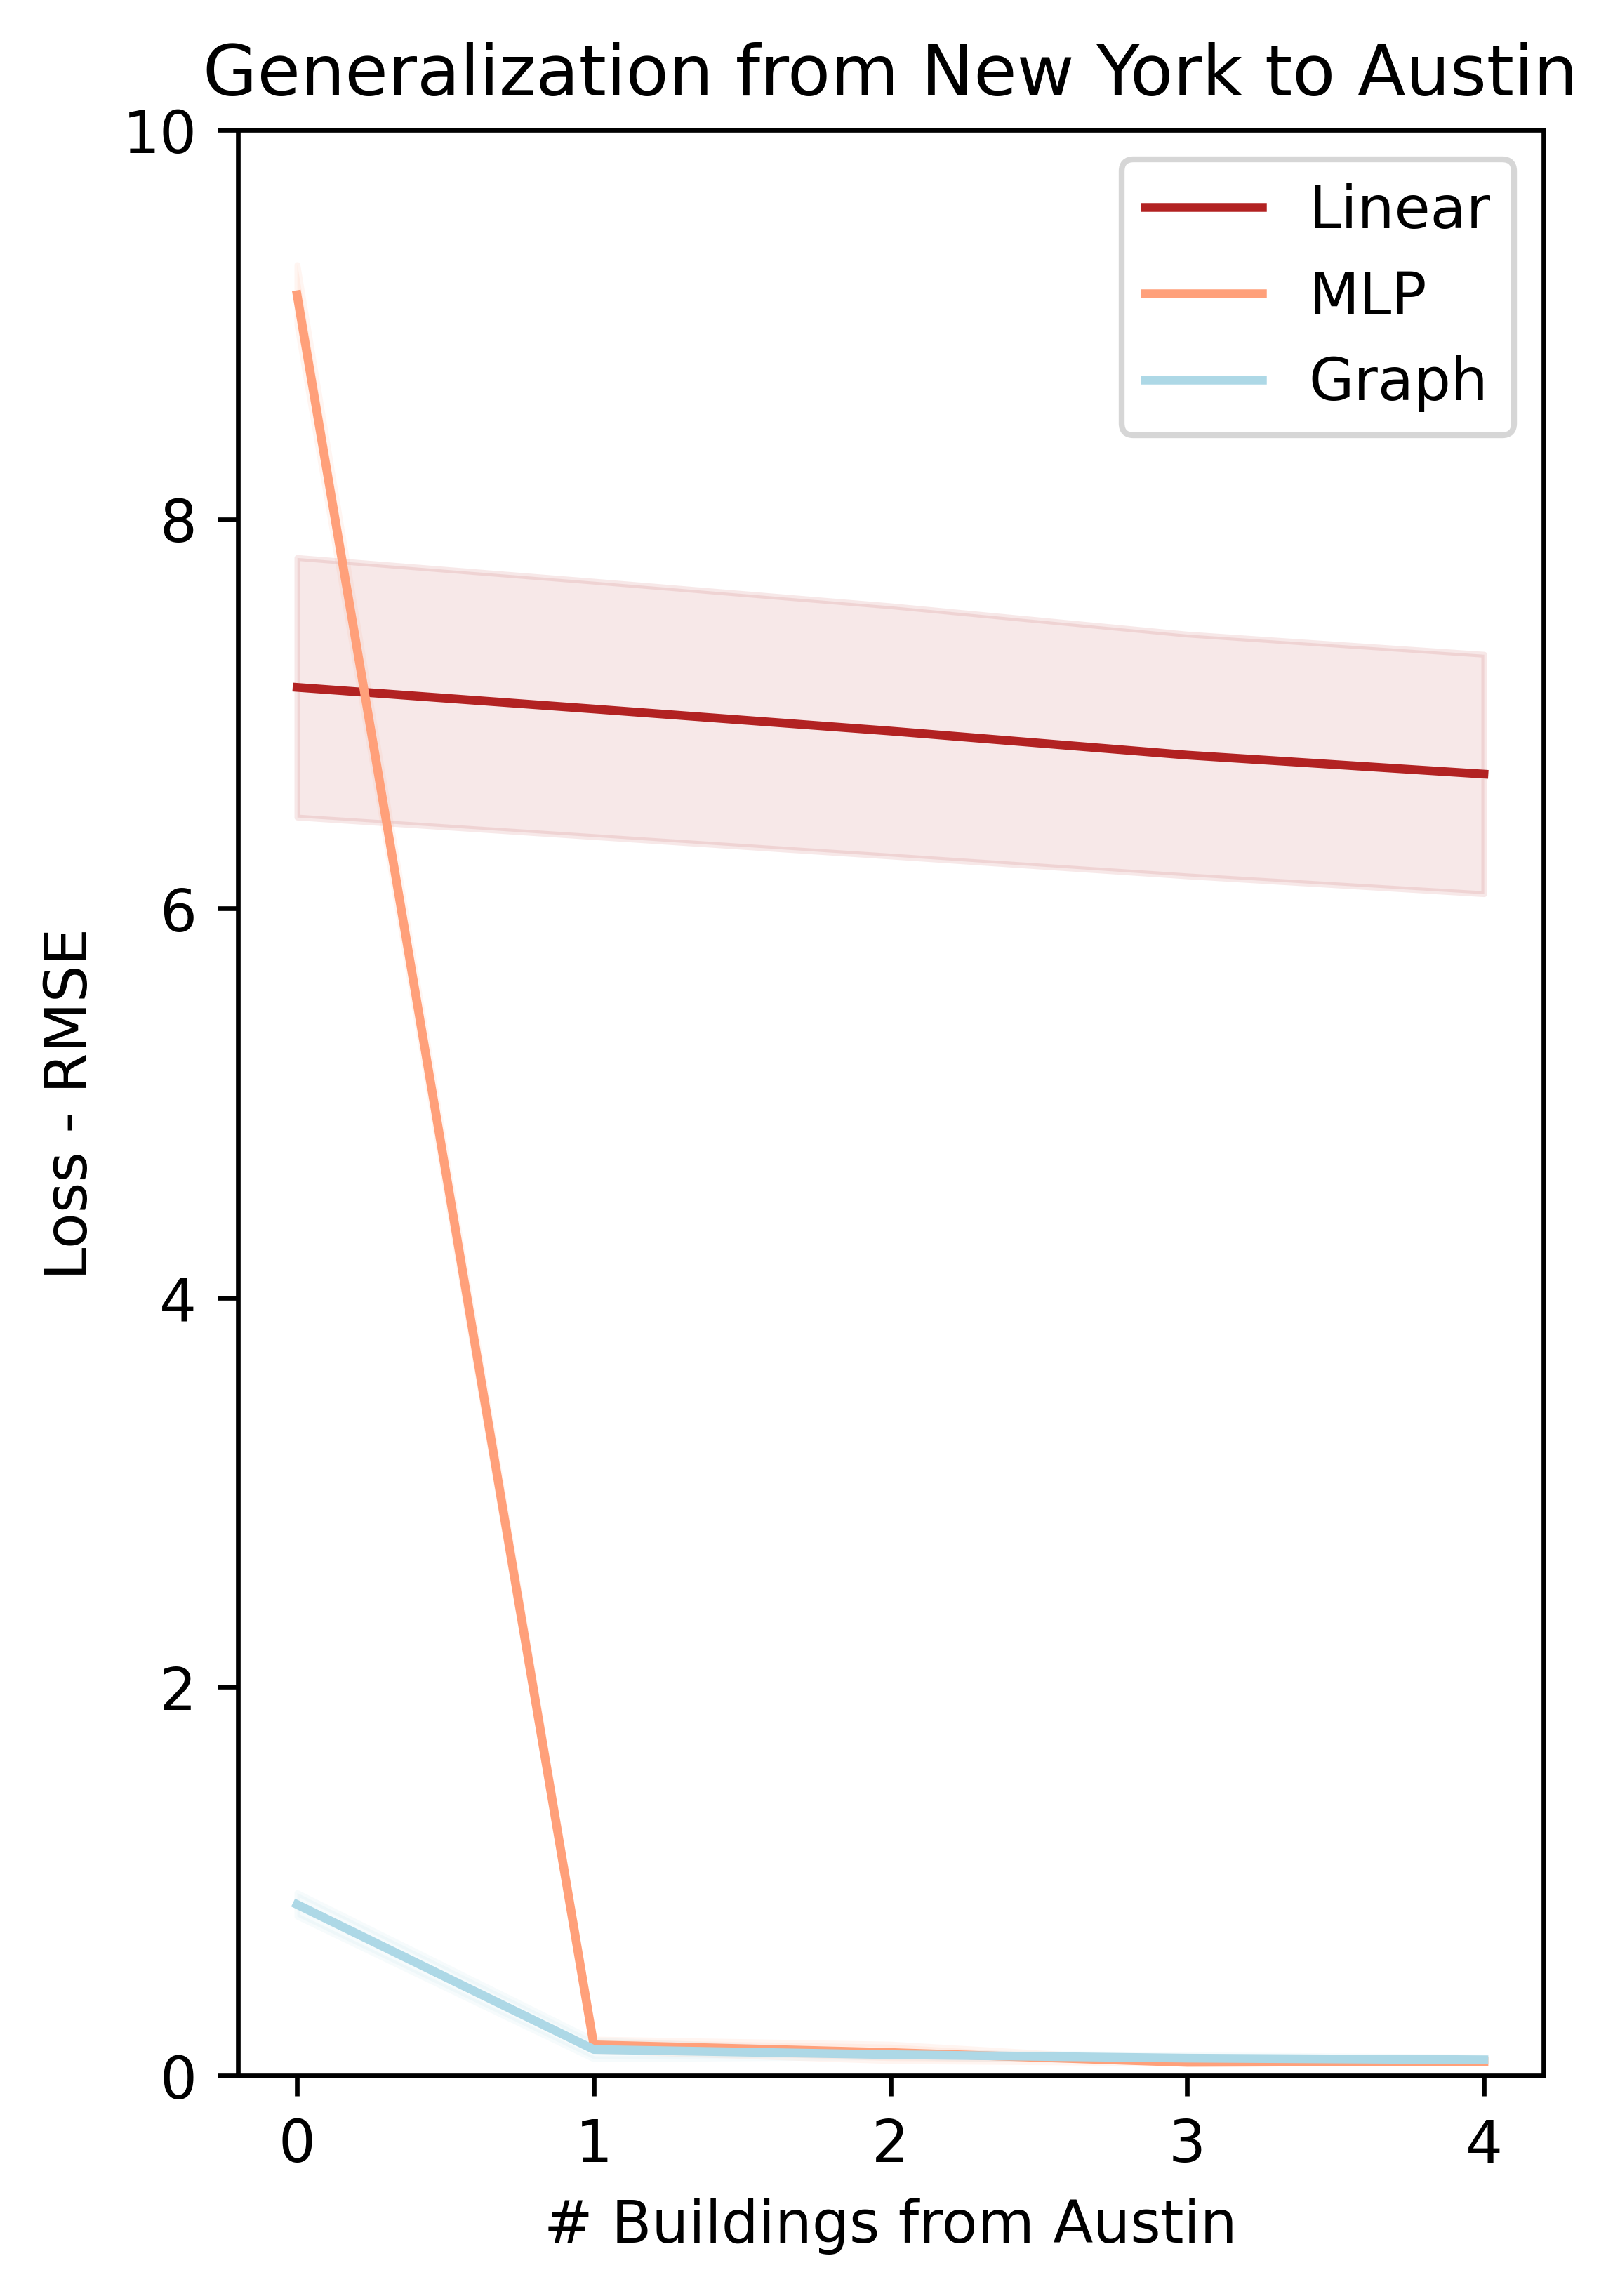

In [207]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(4, 6), dpi=600)

# plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
# plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
# plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")

plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
plt.fill_between(
    np.arange(austin_linearvalloss.shape[0]), 
    np.percentile(austin_linearvalloss, lower, axis=1), 
    np.percentile(austin_linearvalloss, upper, axis=1), 
    color="firebrick", 
    alpha=0.1
)

plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(austin_nullvalloss.shape[0]), 
    np.percentile(austin_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(austin_valloss.shape[0]), 
    np.percentile(austin_valloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend(loc='upper right')
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to Austin")
plt.xlabel("# Buildings from Austin")
plt.ylabel("Loss - RMSE")

plt.ylim((0,10))
plt.savefig(os.path.join(results_dir, 'austin_generalization.png'), bbox_inches="tight")

plt.show()

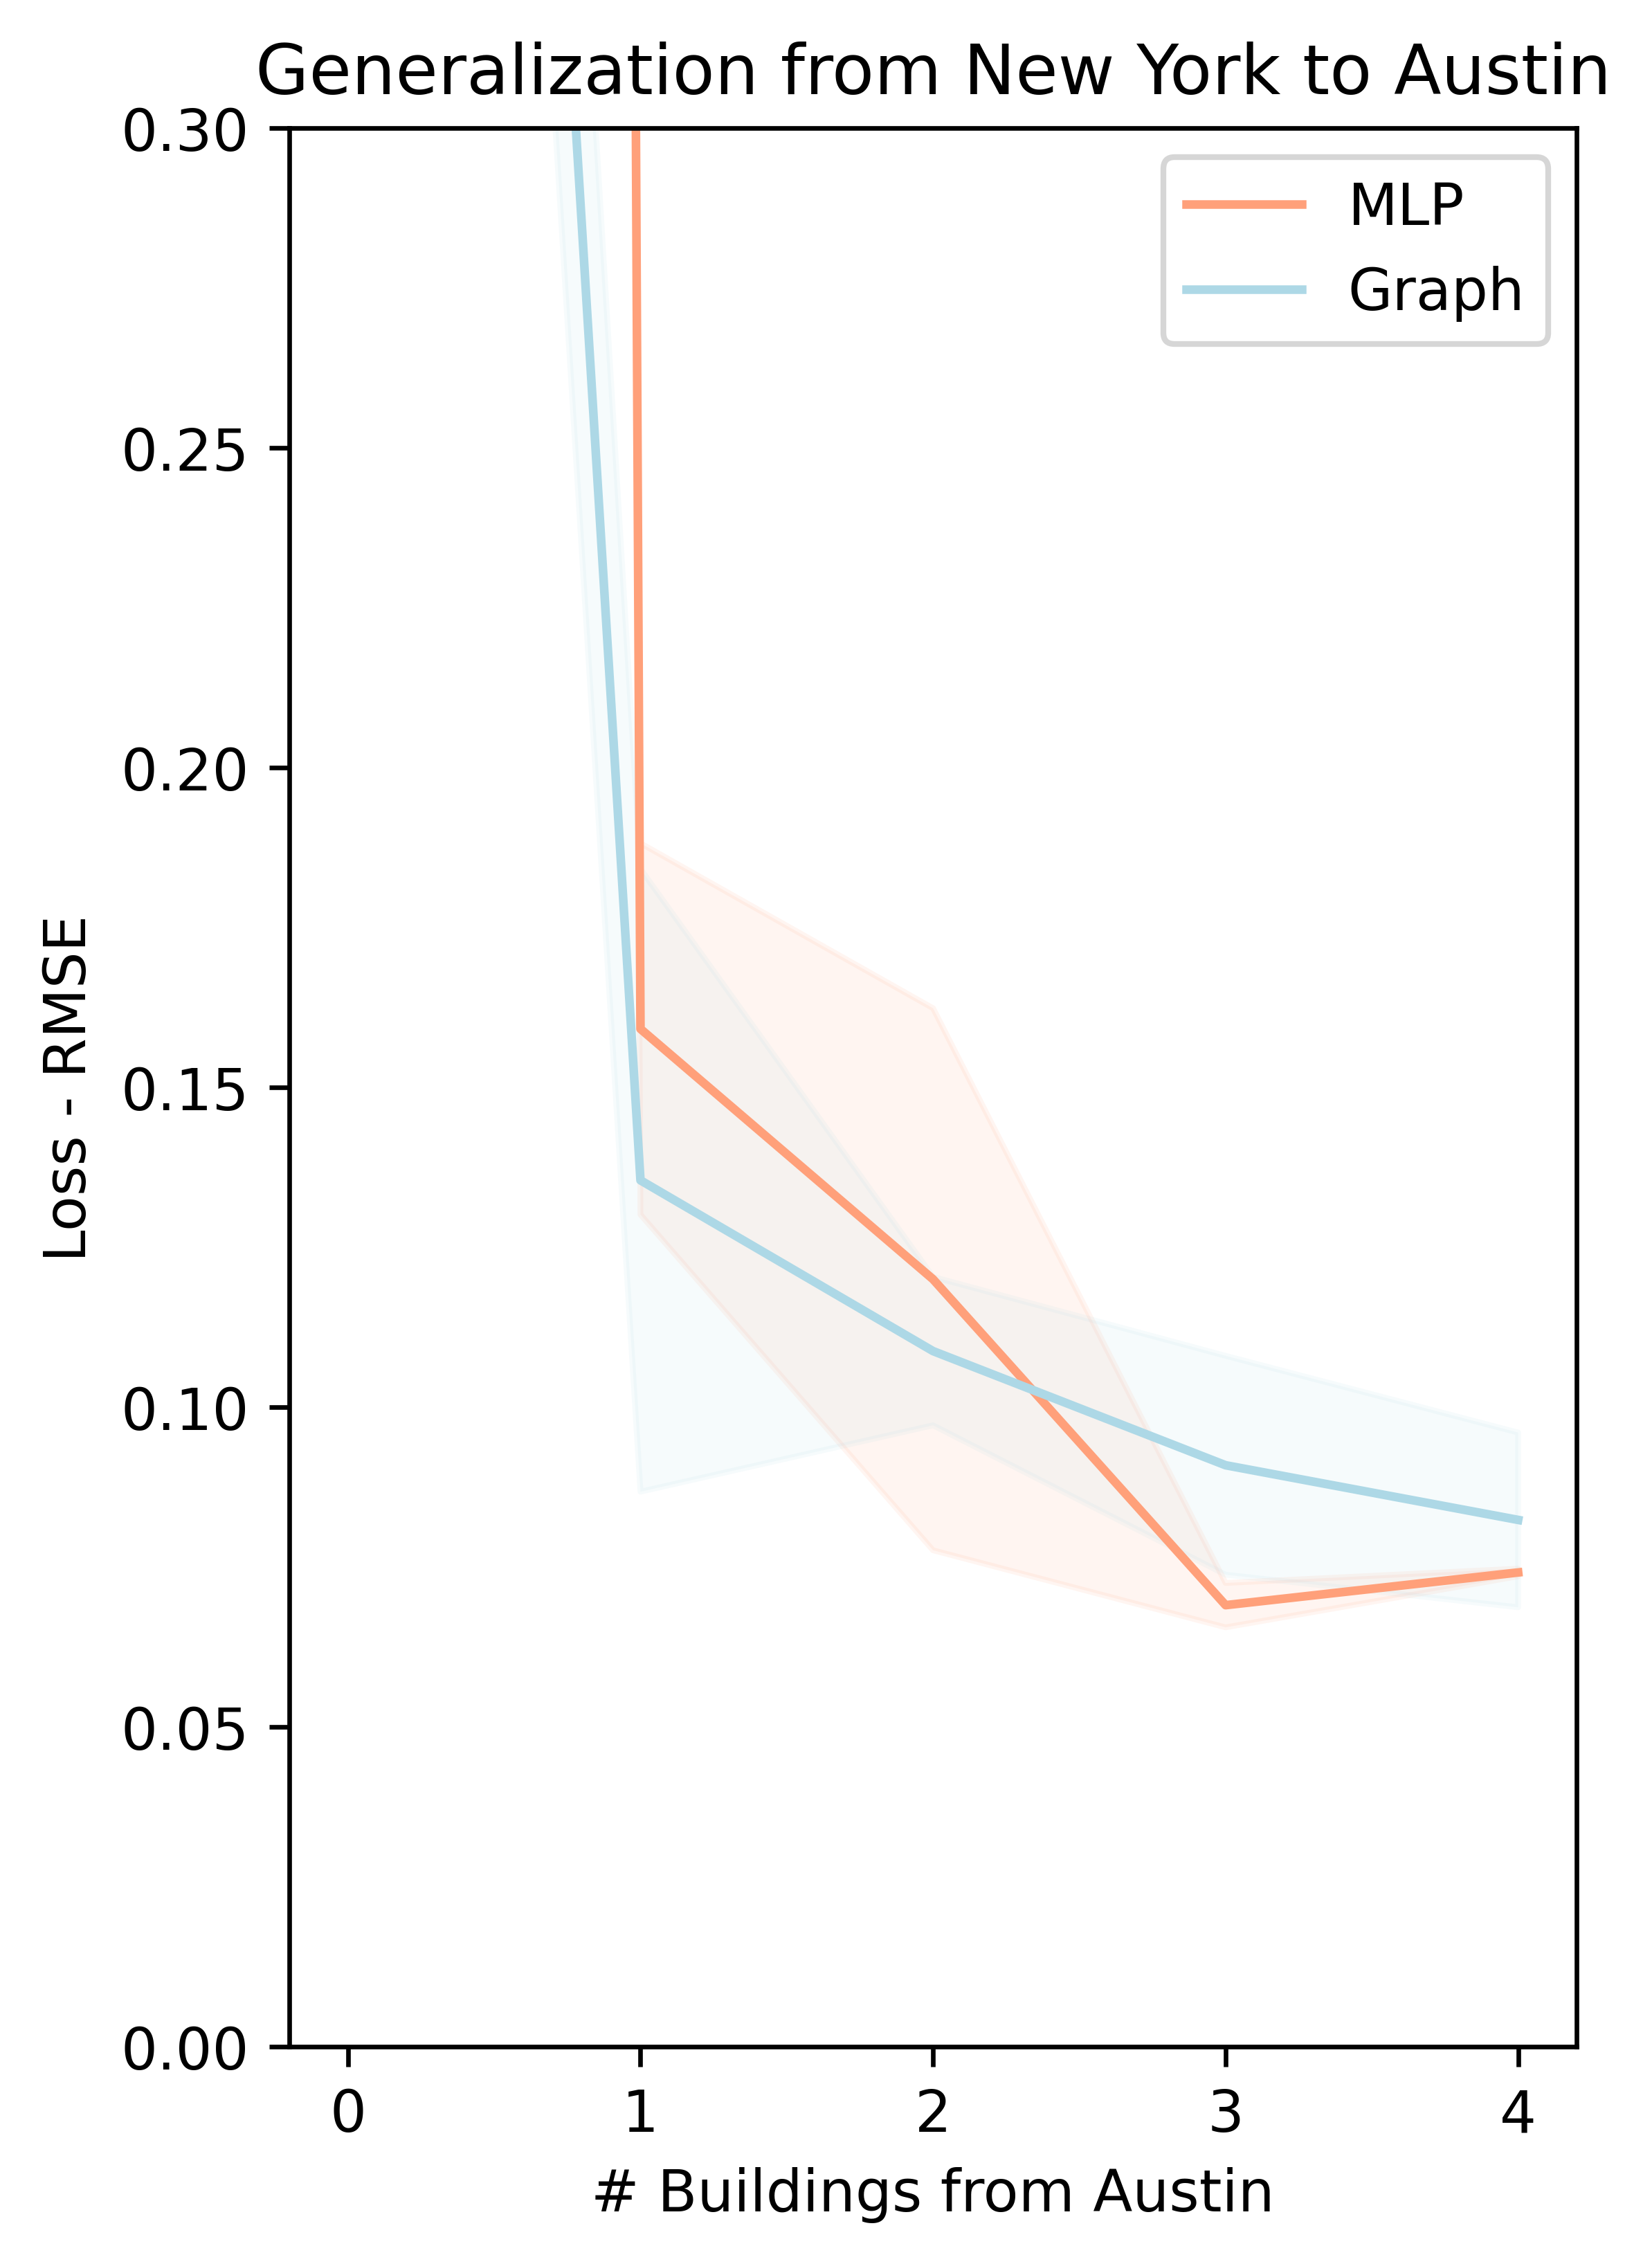

In [208]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(4, 6), dpi=600)

# plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
# plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
# plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")

# plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
# plt.fill_between(
#     np.arange(austin_linearvalloss.shape[0]), 
#     np.percentile(austin_linearvalloss, lower, axis=1), 
#     np.percentile(austin_linearvalloss, upper, axis=1), 
#     color="firebrick", 
#     alpha=0.1
# )

plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(austin_nullvalloss.shape[0]), 
    np.percentile(austin_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(austin_valloss.shape[0]), 
    np.percentile(austin_valloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend(loc='upper right')
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to Austin")
plt.xlabel("# Buildings from Austin")
plt.ylabel("Loss - RMSE")

plt.ylim((0,0.3))
plt.savefig(os.path.join(results_dir, 'austin_generalization_small.png'), bbox_inches="tight")

plt.show()

In [209]:
# ookaaay now I want to see how the model might generalize

In [210]:
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))

In [211]:
austin_finetunemodel = copy.deepcopy(model.state_dict())
austin_finetunenullmodel = copy.deepcopy(nullmodel.state_dict())

In [212]:
model.eval()
nullmodel.eval()

austin_nullpreds = nullmodel(g3['footprint'].x)
austin_linearpreds = reg.predict(g3['footprint'].x.cpu().detach())
austin_predictions = model(g3.x_dict, g3.edge_index_dict)

In [213]:
torch.exp(g3['footprint'].y)

tensor([ 45.5369, 110.1780,  38.8694,  48.3637,  73.8942, 218.5564,  52.1943,
         88.1451, 427.7682,  75.8854,  37.5821,  44.9037,  65.8372,  48.7220,
        206.7006,  26.7108,  52.3018,  32.0925,  41.5314,  31.5233, 144.6965,
         93.1488,  88.0476,  50.1309,  72.2943, 135.2180, 227.6171, 284.2820,
        266.5944, 215.7534, 243.2883, 225.0129, 147.6476,  26.3367, 120.8996,
         49.4889,  83.1514, 153.5951, 116.4285, 139.5144,  25.7658,  97.8859,
        176.1021,  72.5088,  85.6511,  56.1802,  49.8233, 125.0937, 113.1851,
        378.3896,  75.7265,  22.6960, 127.3052,  62.1243,  66.3517,  53.0744,
        283.4539,  78.5163, 300.8389,  73.8114, 150.9673,  84.3981, 170.1940,
        201.5779, 219.0326, 100.9628,  17.0547,  71.0041,  90.7943,  51.5129,
        431.8357,  49.4662, 806.0385, 189.7082, 403.0838, 222.2499, 100.9868,
          8.7271,  31.6128, 181.0245,  61.9917,  82.3599, 172.0617,  26.9165,
         31.8598, 175.0935,  86.8277, 104.1502, 160.4515,  92.18

In [214]:
austin_linearpreds.shape

(151,)

In [215]:
anpred = austin_nullpreds.flatten().detach().cpu()
agpred = austin_predictions.flatten().detach().cpu()
alpred = austin_linearpreds

In [216]:
g3a['footprints'].energy

0       45.53693
1      110.17798
2       38.86941
3       48.36371
4       73.89415
         ...    
146    109.77351
147    894.90183
148    171.13702
149     92.72502
150    114.22436
Name: energy, Length: 151, dtype: float64

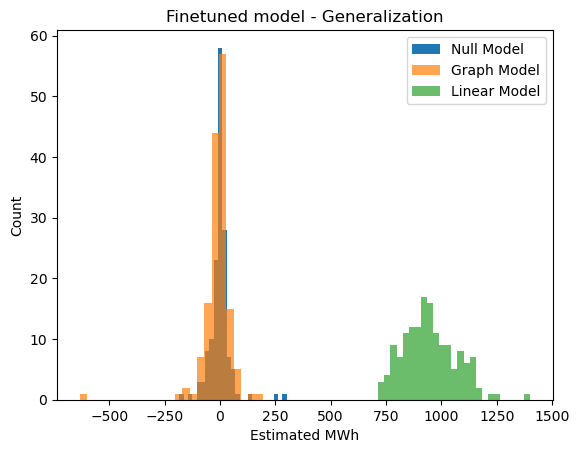

In [217]:
plt.hist(torch.exp(anpred) - g3a['footprints'].energy, bins=25, label="Null Model")
plt.hist(torch.exp(agpred) - g3a['footprints'].energy, bins=25, label="Graph Model", alpha=0.7)
plt.hist(np.exp(austin_linearpreds) - g3a['footprints'].energy, bins=25, label="Linear Model", alpha=0.7)

plt.title("Finetuned model - Generalization")
plt.xlabel("Estimated MWh")
plt.ylabel("Count")

plt.legend()
plt.show()

In [218]:
g3a['footprints']

,id,geometry,energy,area,year,hdd,cdd,logenergy
0,1085710142804825496,"MULTIPOLYGON (((38616.539 3351654.624, 38614.7...",45.53693,350.523019,2019,0.0,9360.480721,3.818524
1,4808974551147681387,"MULTIPOLYGON (((38854.524 3351228.998, 38862.0...",110.17798,1226.319600,2019,0.0,11087.929321,4.702097
2,10355343096648349033,"MULTIPOLYGON (((38401.787 3351347.850, 38405.0...",38.86941,518.120031,2019,0.0,10029.866285,3.660208
3,15106219264146676479,"MULTIPOLYGON (((38704.016 3351658.139, 38712.0...",48.36371,308.437960,2019,0.0,9681.650510,3.878750
4,1296055848080074292,"MULTIPOLYGON (((39049.115 3351352.072, 39053.8...",73.89415,559.276060,2019,0.0,10887.023835,4.302634
...,...,...,...,...,...,...,...,...
146,10592222657494720487,"MULTIPOLYGON (((49186.972 3360821.173, 49187.0...",109.77351,640.287476,2019,0.0,9861.861385,4.698419
147,15501948286802741310,"MULTIPOLYGON (((42209.376 3343321.414, 42230.4...",894.90183,7325.401550,2019,0.0,8547.212982,6.796714
148,4767783814670205981,"MULTIPOLYGON (((42152.398 3343318.675, 42149.0...",171.13702,1551.480100,2019,0.0,8493.564491,5.142465
149,3824251073730738734,"MULTIPOLYGON (((42104.972 3347333.183, 42106.8...",92.72502,1723.536456,2019,0.0,11021.506428,4.529638


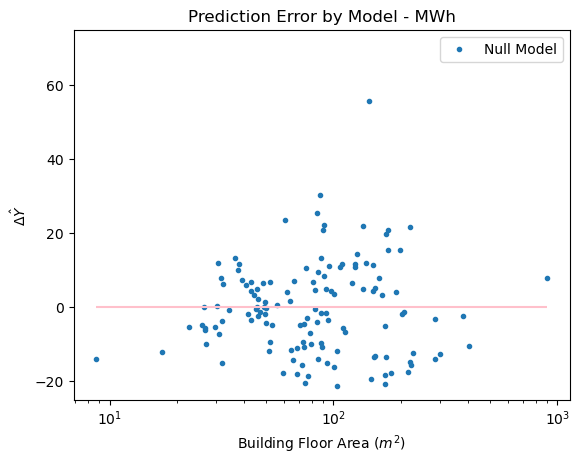

In [219]:
aa = g3a['footprints']['energy']

# plt.plot(aa, np.exp(austin_linearpreds) - g3a['footprints'].energy, '.', label="Linear Model")
plt.plot(aa, np.abs(torch.exp(anpred) - g3a['footprints'].energy) - np.abs(torch.exp(agpred) - g3a['footprints'].energy), '.', label="Null Model")
# plt.plot(aa, np.abs(torch.exp(agpred) - g3a['footprints'].energy), '.', label="Graph Model")

plt.hlines(0, aa.min(), aa.max(), color="pink")

plt.ylabel("$\Delta \hat Y$")
plt.xlabel("Building Floor Area ($m^2$)")
plt.title("Prediction Error by Model - MWh")

# plt.yscale("log")
plt.xscale("log")
plt.ylim((-25,75))

plt.legend()
plt.show()

In [220]:
g3p.columns

Index(['id', 'geometry', 'energy', 'area', 'year', 'hdd', 'cdd', 'logenergy',
       'road_area', 'building_area', 'sky_area', 'vegetation_area',
       'road_area_max', 'building_area_max', 'sky_area_max',
       'vegetation_area_max', 'road_area_min', 'building_area_min',
       'sky_area_min', 'vegetation_area_min'],
      dtype='object')

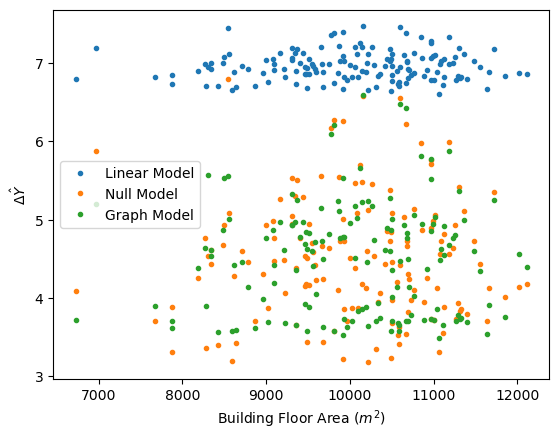

In [221]:
aa = g3p['cdd']

plt.plot(aa, alpred, '.', label="Linear Model")
plt.plot(aa, anpred, '.', label="Null Model")
plt.plot(aa, agpred, '.', label="Graph Model")

plt.ylabel("$\Delta \hat Y$")
plt.xlabel("Building Floor Area ($m^2$)")

plt.legend()
plt.show()

In [222]:
## building the linear model
x_linear_addition = nyX

# print(f"Y shape: {nyY.shape}.")
# print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
y_linear_addition = nyY

linearmodel = ElasticNet()
reg = linearmodel.fit(x_linear_addition, y_linear_addition)

In [223]:
model.load_state_dict(nystate_dict)
model.to(device)

nullmodel.load_state_dict(nullnystate_dict)
nullmodel.to(device)

model.eval()
nullmodel.eval()

austin_nullpredsnf = nullmodel(g3['footprint'].x).cpu().detach()
austin_linearpredsnf = reg.predict(g3['footprint'].x.cpu().detach())
austin_predictionsnf = model(g3.x_dict, g3.edge_index_dict).cpu().detach()

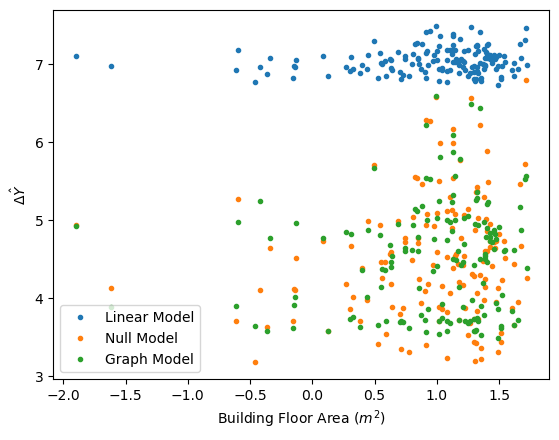

In [224]:
aa = g3p['sky_area']

plt.plot(aa, austin_linearpredsnf, '.', label="Linear Model")
plt.plot(aa, austin_nullpredsnf, '.', label="Null Model")
plt.plot(aa, austin_predictionsnf, '.', label="Graph Model")

plt.ylabel("$\Delta \hat Y$")
plt.xlabel("Building Floor Area ($m^2$)")

plt.legend()
plt.show()